In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import sklearn, matplotlib, shap
print(
    f"scikit-learn: {sklearn.__version__}\n"
    f"matplotlib: {matplotlib.__version__}\n"
    f"SHAP: {shap.__version__}"
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import xgboost
from xgboost import XGBClassifier
print("XGBoost version:", xgboost.__version__)  

scikit-learn: 1.4.0
matplotlib: 3.8.0
SHAP: 0.45.0
XGBoost version: 3.0.0


# Обучение с учителем: качество модели

Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Отделу маркетинга поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Руководитель отдела сформировал задание:
1.	Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2.	Нужно собрать данные по клиентам по следующим группам: 
o	Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
o	Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
o	Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
o	Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
Группы признаков (вместе с целевым) представлены в виде диаграммы Исикавы.

Задачи:
1.	Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2.	В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3.	Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Описание данных: Данные для работы находятся в нескольких таблицах. 

Таблица данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. market_file.csv:
•	id — номер покупателя в корпоративной базе данных.
•	Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
•	Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
•	Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
•	Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
•	Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
•	Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
•	Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
•	Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
•	Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
•	Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
•	Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
•	Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица данных о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом. market_money.csv
•	id — номер покупателя в корпоративной базе данных.
•	Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
•	Выручка — сумма выручки за период.

Таблица данных о времени (в минутах), которое покупатель провёл на сайте в течение периода. market_time.csv
•	id — номер покупателя в корпоративной базе данных.
•	Период — название периода, во время которого зафиксировано общее время.
•	минут — значение времени, проведённого на сайте, в минутах.

Таблица данных о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. money.csv
•	id — номер покупателя в корпоративной базе данных.
•	Прибыль — значение прибыли.

Этапы решения задачи:
1.	Разработка модели, которая предскажет вероятность снижения покупательской активности.
2.	Выделение сегмента покупателей, анализ его и предложение, как увеличить его покупательскую активность, используя данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). 

Анализ других сегментов: 
o	Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
o	Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
o	Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
o	Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Шаг 1. Загрузка данных

1.1 Загрузите данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv через пути к ним:
•	/datasets/market_file.csv
•	/datasets/market_money.csv
•	/datasets/market_time.csv
•	/datasets/money.csv

In [7]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pathlib import Path

# Предобработка данных
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest

# Модели и оценка
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# SHAP
import shap
from shap import KernelExplainer

# Параллельные вычисления
from joblib import Parallel

In [8]:
# Загрузим файл с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
data_dir = Path(r'C:\GitProjects\Supervised_Learning_Real\data')

market_file = pd.read_csv(data_dir / 'market_file.csv')
display(market_file.head(10))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [9]:
# Выведем информацию о данных
print(market_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
print(market_file["Покупательская активность"].value_counts())

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64


В данных отсутствуют пропуски.

Категориальные данные:
-Покупательская активность
-Тип сервиса
-Разрешить сообщать 
-Популярная_категория.

Количественные данные в %:
-Маркет_актив_6_мес 
-Акционные_покупки.

Временные данные:
-Длительность, в сек.

In [11]:
# Загрузим файл с данными о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом
market_money = pd.read_csv(data_dir /'market_money.csv', decimal=',')
display(market_money.head(10))

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [12]:
# Выведем информацию о данных market_money
print(market_money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB
None


В данных отсутствуют пропуски. Типы данных: Столбец Период содержит категориальные данные. Столбец Выручка содержит количественные данные в рублях.

In [13]:
# Загрузим файл с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
market_time = pd.read_csv(data_dir /'market_time.csv', decimal=',')
display(market_time.head(10))

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [14]:
# Посчитаем все значения в столбце "Период"
unique_periods = market_time['Период'].unique()

print(f'Количество уникальных периодов: {len(unique_periods)}')
print(f'Уникальные периоды: {unique_periods}')

Количество уникальных периодов: 2
Уникальные периоды: ['текущий_месяц' 'предыдцщий_месяц']


In [15]:
# Заменим 'предыдцщий_месяц' на 'предыдущий_месяц'
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

# Посчитаем количество каждого уникального периода
period_counts = market_time['Период'].value_counts()

print(period_counts)

Период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64


In [16]:
# Выведем информацию о данных market_time
print(market_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


В данных отсутствуют пропуски. Типы данных: Столбец Период содержит категориальные данные. Столбец минут: содержит данные о продолжительности звонков в минутах.

In [17]:
# Загрузим файл с данными о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом
money = pd.read_csv(data_dir /'money.csv', sep=';', decimal=',')
display(money.head(10))

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [18]:
# Выведем информацию о данных market_time
print(money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


В данных отсутствуют пропуски. Типы данных: Столбец Прибыль содержит значение прибыли.

Шаг 2. Предобработка данных

In [19]:
num_duplicates = market_file.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


In [20]:
# Замена значений
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')

# Вывод
print(market_file['Тип сервиса'].value_counts())

Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64


In [21]:
# Удалим дубликаты
market_file = market_file.drop_duplicates()

# Выведем информацию о данных
print(market_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [22]:
num_duplicates = market_money.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


In [23]:
num_duplicates = market_time.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


In [24]:
num_duplicates = money.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


Шаг 3. Исследовательский анализ данных

-Проведите исследовательский анализ данных из каждой таблицы. 
-Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 
-Оформите выводы по результатам шага.

In [25]:
# Описание данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении в таблице market_file
print("Описание данных о поведении покупателя на сайте в таблице market_file:")
display(market_file.describe())

Описание данных о поведении покупателя на сайте в таблице market_file:


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Покупатели в среднем совершают 4,25 транзакций за последние 6 месяцев и 4,01 транзакции за последний месяц - относительно часто. Средняя продолжительность сеанса составляет 601,89 сек (около 10 мин) - значительное количество времени на сайте за один сеанс.
В среднем совершается 3,27 акционные покупки в квартал - покупатели восприимчивы к акциям и скидкам, просматривают 0,32 категории за визит - сосредоточены на определенных категориях товаров, оставляют 3,27 неоплаченных товара в квартал - есть привычка добавлять товары в корзину, но не завершать покупку.
Покупатели сталкиваются с 2,84 ошибками в обслуживании, что может негативно сказаться на опыте покупок и привести к потере клиентов.
В среднем просматривается 4,19 страниц за визит, значит покупатели относительно активны на сайте и ищут различные товары.

In [26]:
# Отберем клиентов с покупательской активностью Снизилась
active_customers = market_file[market_file['Покупательская активность'] == 'Снизилась']

# Выведем информацию о данных
display(active_customers.info())

<class 'pandas.core.frame.DataFrame'>
Index: 498 entries, 0 to 593
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   498 non-null    int64  
 1   Покупательская активность            498 non-null    object 
 2   Тип сервиса                          498 non-null    object 
 3   Разрешить сообщать                   498 non-null    object 
 4   Маркет_актив_6_мес                   498 non-null    float64
 5   Маркет_актив_тек_мес                 498 non-null    int64  
 6   Длительность                         498 non-null    int64  
 7   Акционные_покупки                    498 non-null    float64
 8   Популярная_категория                 498 non-null    object 
 9   Средний_просмотр_категорий_за_визит  498 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   498 non-null    int64  
 11  Ошибка_сервиса                       

None

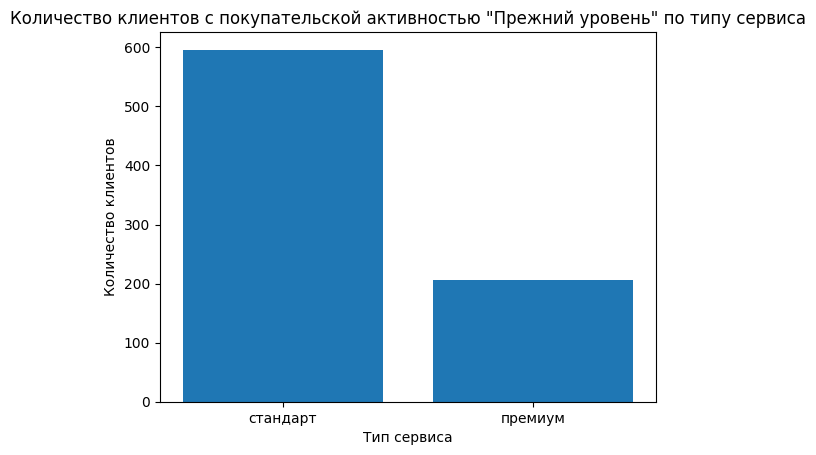

In [27]:
# Выделим клиентов с покупательской активностью "Прежняя"
active_customers = market_file[market_file['Покупательская активность'] == 'Прежний уровень']

# Определим количество клиентов с типом сервиса "Премиум" и 'Стандарт' в Покупательская активность "Прежняя"
num_standard = active_customers[active_customers['Тип сервиса'] == 'стандарт'].shape[0]
num_premium = active_customers[active_customers['Тип сервиса'] == 'премиум'].shape[0]

# Построим график
plt.bar(['стандарт', 'премиум'], [num_standard, num_premium])
plt.xlabel('Тип сервиса')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов с покупательской активностью "Прежний уровень" по типу сервиса')
plt.show()

In [28]:
# Отберем клиентов с покупательской активностью "Прежний уровень"
active_customers = market_file[market_file['Покупательская активность'] == 'Прежний уровень']

# Отберем количество клиентов с типом сервиса 'Стандарт'
num_standard = active_customers[active_customers['Тип сервиса'] == 'стандарт'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Стандарт'
standard_customers = active_customers[active_customers['Тип сервиса'] == 'стандарт']
display(standard_customers.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
400,215748,Прежний уровень,стандарт,нет,4.3,4,534,0.18,Кухонная посуда,3,1,4,10
402,215750,Прежний уровень,стандарт,да,4.8,5,634,0.21,Товары для детей,4,5,3,10
403,215751,Прежний уровень,стандарт,да,4.1,4,957,0.17,Техника для красоты и здоровья,5,2,6,9
404,215752,Прежний уровень,стандарт,нет,4.0,4,475,0.30,Мелкая бытовая техника и электроника,3,3,7,7
407,215755,Прежний уровень,стандарт,да,4.4,4,216,0.18,Техника для красоты и здоровья,2,3,5,13


In [29]:
display(standard_customers.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,216240.817114,4.587081,4.050336,545.763423,0.241493,3.758389,2.236577,4.345638,9.533557
std,245.910017,0.860106,0.679211,244.141520,0.166756,1.282859,1.509434,1.944956,3.306304
min,215748.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,216044.750000,4.000000,4.000000,347.750000,0.160000,3.000000,1.000000,3.000000,7.000000
50%,216244.500000,4.400000,4.000000,525.500000,0.210000,4.000000,2.000000,4.000000,9.000000
75%,216455.250000,5.300000,5.000000,748.250000,0.260000,5.000000,3.000000,6.000000,12.000000
max,216646.000000,6.600000,5.000000,1052.000000,0.990000,6.000000,8.000000,9.000000,19.000000


1.В датасете Покупательская активность 'Прежний уровень' и Тип сервиса 'стандарт' содержится 596 клиентов - представительная выборка для анализа.

2.Средняя маркетинговая активность за 6 месяцев - 4.59 - умеренная. Маркетактивтекмес – 4.05 - некоторое снижение активности в последнее время.

3.Средняя длительность визита - 545.76 сек - клиенты заинтересованы в продуктах, хотя и существует значительное разнообразие по длительности визитов (стандартное отклонение 244.14).

4.В среднем клиенты совершают 0.24 акционные покупки за визит - акции не всегда привлекают внимание клиентов или не являются основной мотивацией для покупок.

5.3.76 категорий просматривается за визит - клиенты исследуют несколько категорий продуктов, но не уходят слишком далеко от своих первоначальных интересов.

6.Среднее значение неоплаченных продуктов - 2.24 шт за квартал - некоторые клиенты добавляют продукты в корзину, но не завершают покупку.

7.Среднее количество ошибок сервиса составляет 4.35 за визит - необходимо улучшение качества сервиса - ошибки могут негативно влиять на опыт клиента и на уровень его активности.

8.В среднем клиенты просматривают 9.53 страниц за визит, что говорит о заинтересованности, но также может указывать на необходимость в навигации, если клиенты просматривают так много страниц, прежде чем совершить покупку.

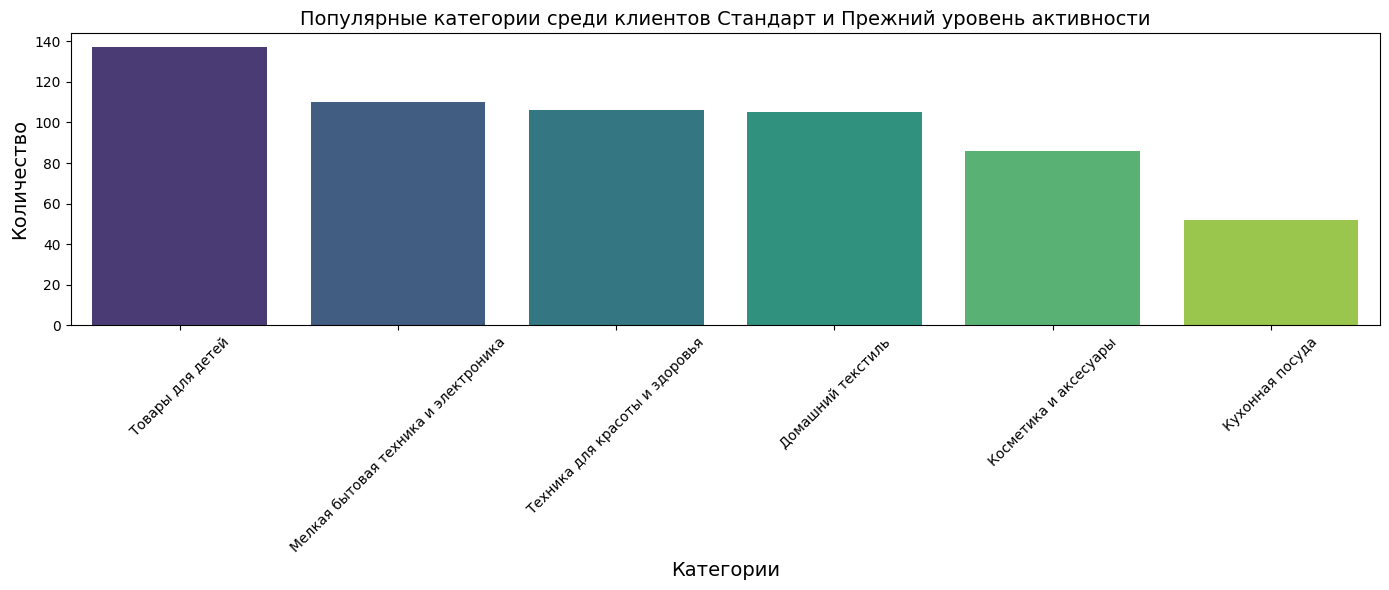

In [30]:
# считаем количество записей для каждой категории
category_counts = standard_customers['Популярная_категория'].value_counts()

# Построение диаграммы
plt.figure(figsize=(14, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='viridis', legend=False)

# Настройка заголовка и меток
plt.title('Популярные категории среди клиентов Стандарт и Прежний уровень активности', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Показать график
plt.show()

In [31]:
# Отберем клиентов с покупательской активностью "Прежний уровень"
active_customers = market_file[market_file['Покупательская активность'] == 'Прежний уровень']

# Отберем количество клиентов с типом сервиса 'Премиум'
num_premium = active_customers[active_customers['Тип сервиса'] == 'премиум'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Премиум'
premium_customers = active_customers[active_customers['Тип сервиса'] == 'премиум']
display(premium_customers.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
401,215749,Прежний уровень,премиум,да,5.8,5,624,0.30,Техника для красоты и здоровья,4,3,6,14
405,215753,Прежний уровень,премиум,да,5.5,5,191,0.17,Косметика и аксесуары,6,0,4,8
406,215754,Прежний уровень,премиум,да,4.6,3,937,0.14,Домашний текстиль,5,2,4,14
410,215758,Прежний уровень,премиум,да,5.7,5,486,0.15,Мелкая бытовая техника и электроника,4,4,4,9
411,215759,Прежний уровень,премиум,да,3.6,5,589,0.21,Кухонная посуда,3,1,4,6


In [32]:
display(premium_customers.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,206.00000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,216228.92233,4.520874,3.898058,720.830097,0.229320,3.398058,2.456311,4.305825,10.558252
std,247.50711,0.814503,0.708345,242.578617,0.141268,1.224464,1.496511,2.080962,3.470293
min,215749.00000,2.400000,3.000000,150.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,216048.00000,4.000000,3.000000,568.500000,0.150000,2.250000,1.000000,3.000000,8.000000
50%,216248.50000,4.400000,4.000000,762.500000,0.210000,3.000000,2.000000,4.000000,11.000000
75%,216423.25000,5.200000,4.000000,920.500000,0.260000,4.000000,4.000000,6.000000,13.000000
max,216647.00000,6.600000,5.000000,1061.000000,0.990000,6.000000,6.000000,9.000000,20.000000


1.В выборке содержится 206 клиентов, что позволяет проводить анализ, хотя и меньше, чем в предыдущем случае.

2.Средняя активность за 6 месяцев 4.52 - стабильная активность в диапазоне "Прежний уровень". Текущая активность несколько ниже - 3.90 - снижение интереса или изменения в покупательских привычках.

3.Средняя длительность визита - 720.83 сек - значительно больше, чем у клиентов с типом сервиса 'Стандарт' - более глубокое вовлечение клиентов в процесс выбора и покупки.

4.Среднее количество акционных покупок за визит - 0.23 - сопоставимо с предыдущей группой - клиенты не склонны активно участвовать в акциях.

5.Средний просмотр категорий - 3.40 категории за визит - меньше по сравнению с клиентами 'Стандарт'.

6.Среднее число неоплаченных продуктов - 2.46 шт за квартал - немного выше, чем в предыдущей группе - клиенты добавляют больше товаров в корзину, но не завершают покупку.

7.Среднее значение ошибок сервиса - 4.31 за визит - сопоставимо с предыдущей группой - необходимо продолжать работу над устранением проблем с сервисом.

8.В среднем клиенты просматривают 10.56 страниц за визит - высокий интерес к продуктам, но может также указывать на сложности в навигации.

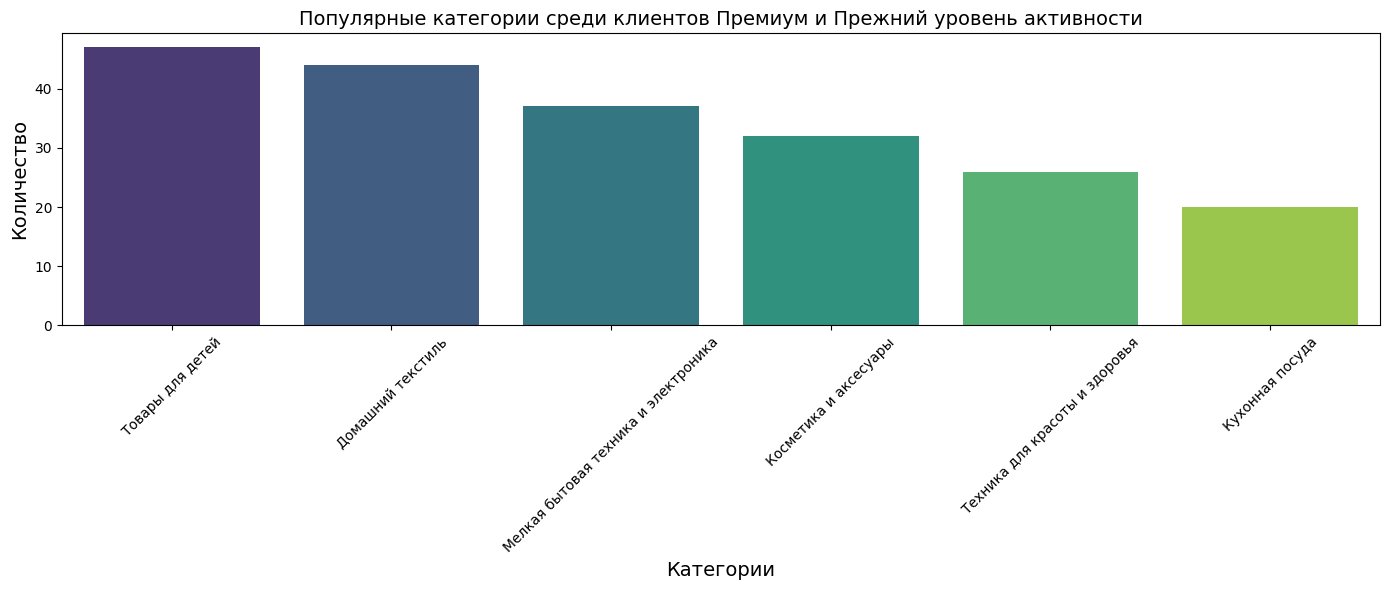

In [33]:
# считаем количество записей для каждой категории
category_counts = premium_customers['Популярная_категория'].value_counts()

# Построение диаграммы
plt.figure(figsize=(14, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='viridis', legend=False)

# Настройка заголовка и меток
plt.title('Популярные категории среди клиентов Премиум и Прежний уровень активности', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Показать график
plt.show()

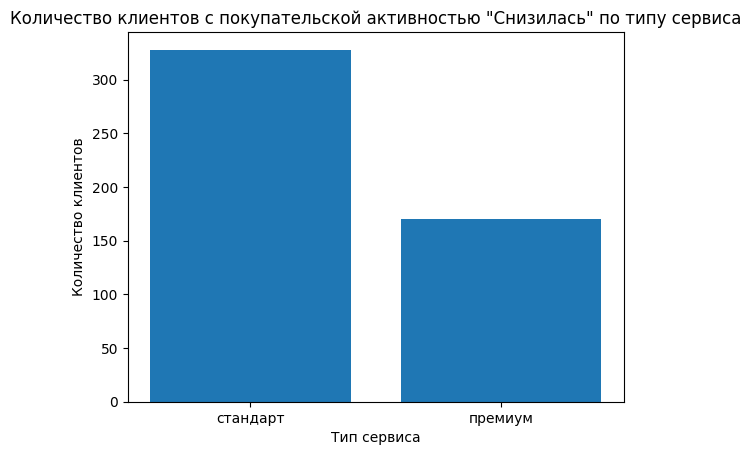

In [34]:
# Выделим клиентов с покупательской активностью "Снизилась"
active_customers = market_file[market_file['Покупательская активность'] == 'Снизилась']

# Определим количество клиентов с типом сервиса "Премиум" и 'Стандарт' в Покупательская активность "Прежняя"
num_standard = active_customers[active_customers['Тип сервиса'] == 'стандарт'].shape[0]
num_premium = active_customers[active_customers['Тип сервиса'] == 'премиум'].shape[0]

# Построим график
plt.bar(['стандарт', 'премиум'], [num_standard, num_premium])
plt.xlabel('Тип сервиса')
plt.ylabel('Количество клиентов')
plt.title('Количество клиентов с покупательской активностью "Снизилась" по типу сервиса')
plt.show()

In [35]:
# Отберем клиентов с покупательской активностью "Снизилась"
passive_customers = market_file[market_file['Покупательская активность'] == 'Снизилась']

# Отберем количество клиентов с типом сервиса 'Стандарт'
num_standard = passive_customers[passive_customers['Тип сервиса'] == 'стандарт'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Стандарт'
standard_customers = passive_customers[passive_customers['Тип сервиса'] == 'стандарт']
display(standard_customers.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2


In [36]:
display(standard_customers.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,215620.722561,3.806098,4.030488,565.704268,0.443720,2.685976,3.750000,3.804878,5.560976
std,169.443303,1.062580,0.698831,230.887573,0.304809,1.295317,2.307745,1.828681,3.701715
min,215350.000000,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,215482.500000,3.300000,4.000000,376.000000,0.240000,2.000000,2.000000,2.000000,3.000000
50%,215612.000000,3.900000,4.000000,572.500000,0.300000,2.000000,4.000000,4.000000,5.000000
75%,215732.250000,4.450000,5.000000,731.250000,0.890000,3.000000,5.000000,5.000000,7.000000
max,215941.000000,6.600000,5.000000,1064.000000,0.990000,6.000000,10.000000,9.000000,18.000000


1.В выборке содержится 328 клиентов, что позволяет проводить достаточно надежный анализ.

2.Средняя маркетинговая активность за 6 месяцев 215620.72, что указывает на стабильность, но невысокий уровень вовлеченности. Текущая активность немного ниже среднего значения (3.81) - снижение интереса со стороны клиентов категории Стандарт.

3.Средняя длительность визита - 4.03 минуты (или 242 секунды) - клиенты в среднем проводят меньше времени на сайте, чем в предыдущей группе с 'Премиум' сервисом.

4.Среднее количество акционных покупок за визит - 0.44 - немного выше по сравнению с предыдущей группой, однако на низком уровне - клиенты не сильно интересуются скидками и акциями.

5.Среднее значение просмотров категорий за визит - 2.69 - клиенты с типом 'Стандарт' исследуют меньше категорий, чем их 'Премиум' аналоги.

6.Среднее количество неоплаченных продуктов - 3.75 шт за квартал - клиенты добавляют в корзину больше товаров, но не завершают покупку, что требует анализа факторов, влияющих на это.

7.Среднее значение ошибок сервиса - 3.80 за визит - некоторые проблемные моменты, требующие внимания для улучшения клиентского опыта.

8.В среднем клиенты просматривают 5.56 страниц за визит - ниже, чем у 'Премиум' клиентов - менее заинтересованное поведение пользователей или проблемы с доступностью информации.

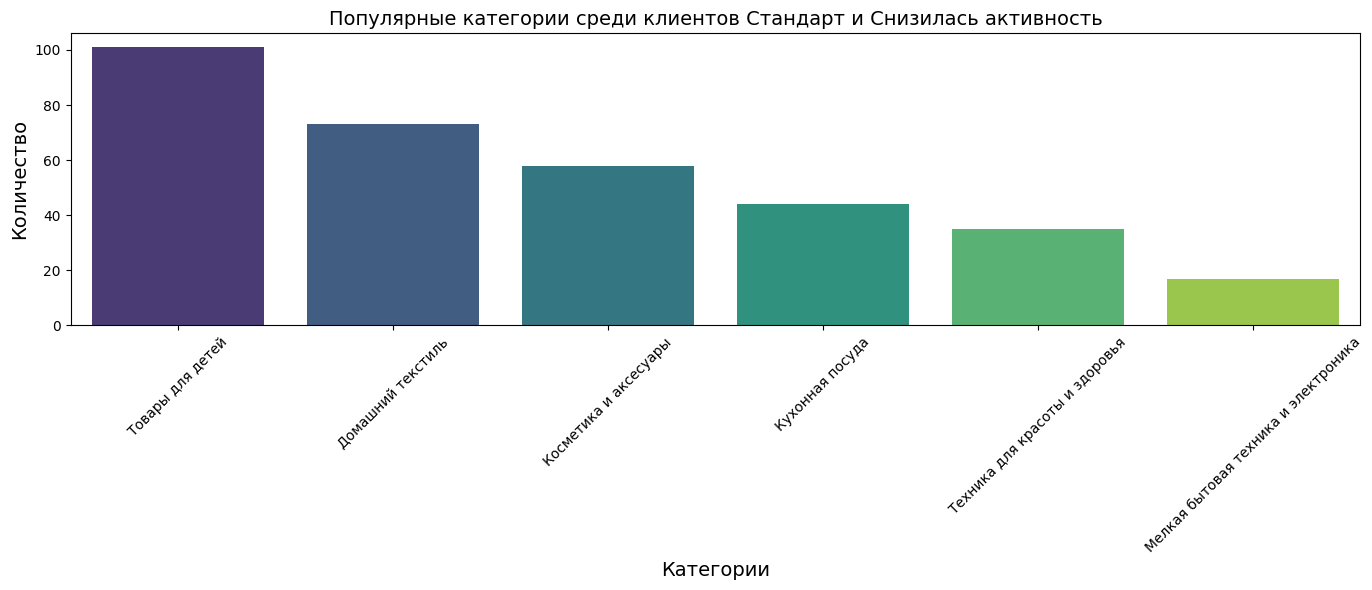

In [37]:
# считаем количество записей для категории Стандарт
category_counts = standard_customers['Популярная_категория'].value_counts()

# Построение диаграммы
plt.figure(figsize=(14, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='viridis', legend=False)

# Настройка заголовка и меток
plt.title('Популярные категории среди клиентов Стандарт и Снизилась активность', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Показать график
plt.show()

In [38]:
# Отберем клиентов с покупательской активностью "Снизилась"
passive_customers = market_file[market_file['Покупательская активность'] == 'Снизилась']

# Отберем количество клиентов с типом сервиса 'Премиум'
num_premium = passive_customers[passive_customers['Тип сервиса'] == 'премиум'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Премиум'
premium_customers = passive_customers[passive_customers['Тип сервиса'] == 'премиум']
display(premium_customers.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
12,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7
14,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4
16,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3


In [39]:
display(premium_customers.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,215590.988235,3.625294,3.976471,724.417647,0.464941,2.529412,3.664706,4.211765,5.582353
std,157.306695,1.028014,0.729375,222.420165,0.308737,1.088816,2.253056,1.988691,2.928484
min,215348.000000,0.900000,3.000000,121.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,215457.500000,3.000000,3.000000,561.000000,0.240000,2.000000,2.000000,3.000000,4.000000
50%,215572.000000,3.850000,4.000000,766.000000,0.320000,3.000000,3.000000,4.000000,5.000000
75%,215699.250000,4.200000,4.750000,886.500000,0.897500,3.000000,5.000000,6.000000,6.750000
max,215940.000000,5.800000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,17.000000


1.В выборке 170 клиентов - достаточно данных для анализа их поведения.

2.Маркетинговая активность за 6 месяцев - 215590.99 - стабильный уровень, хотя и ниже, чем у прежней категории. Текущая активность - 3.63 - на снижение вовлеченности по сравнению с предыдущими периодами.

3.Средняя длительность визита - 3.98 мин (или 238 сек) - снижение интереса к контенту или услуге.

4.Среднее количество акционных покупок - 0.46 за визит - достаточно высокий показатель по сравнению с группой 'Стандарт' - клиенты 'Премиум' все же проявляют интерес к специальным предложениям, несмотря на снижение активности.

5.Среднее значение просмотров категорий за визит - 2.53 - ниже, чем в группе 'Стандарт' - снижение интереса к ассортименту или недостаток внимания к различным категориям.

6.Среднее количество неоплаченных продуктов - 3.66 шт за квартал - клиенты склонны добавлять товары в корзину, но не завершают покупку, что требует более глубокого анализа для понимания причин.

7.Среднее значение ошибок сервиса - 4.21 за визит, что может негативно сказываться на общем клиентском опыте и уровне удовлетворенности.

8.В среднем клиенты просматривают 5.58 страниц за визит, что близко к среднему показателю группы 'Стандарт' - клиенты все еще заинтересованы в исследовании предложений.

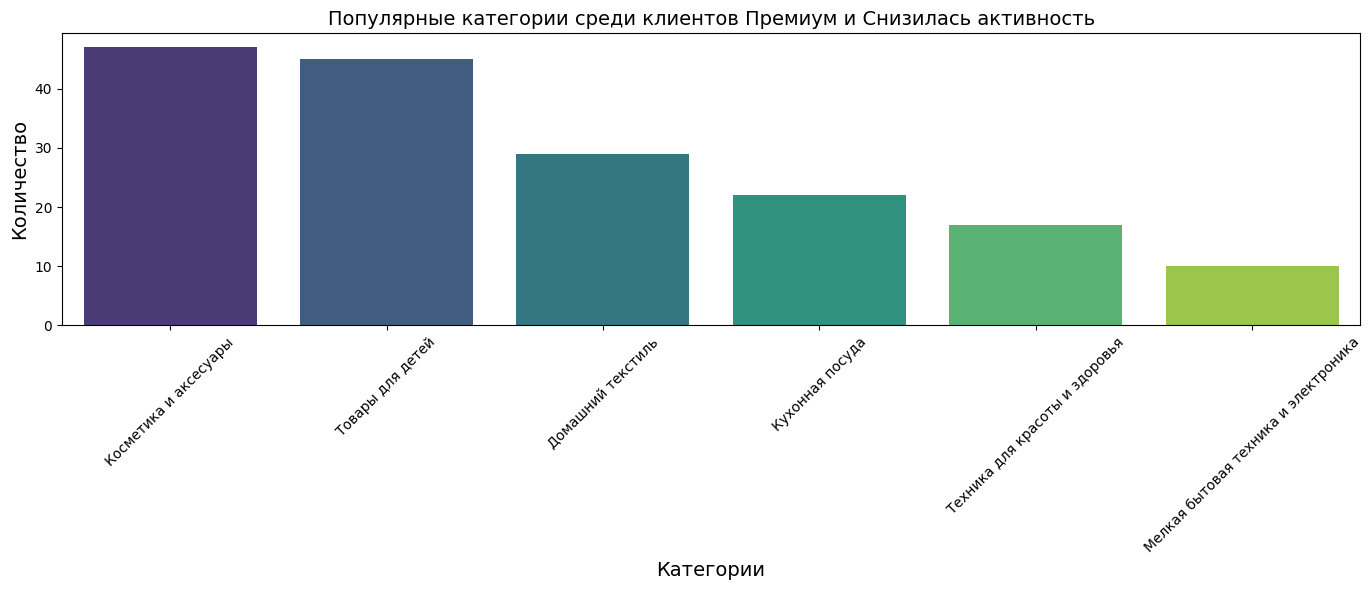

In [40]:
# считаем количество записей для категории Премиум
category_counts = premium_customers['Популярная_категория'].value_counts()

# Построение диаграммы
plt.figure(figsize=(14, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='viridis', legend=False)

# Настройка заголовка и меток
plt.title('Популярные категории среди клиентов Премиум и Снизилась активность', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Показать график
plt.show()

Выводы по популярным категориям среди клиентов Стандарт и Премиум в Покупательской активности Снизилась:

1. Сходство в интересах:
   - Обе группы клиентов (Стандарт и Премиум) имеют схожие предпочтения в отношении популярных категорий товаров. Основные категории, такие как "Товары для детей" и "Домашний текстиль" для группы Стандарт, а также "Косметика и аксессуары" для группы Премиум, указывают на общую тенденцию интереса к товарам для дома и ухода за собой.

2. Приоритеты в категориях:
   - В группе Стандарт на первом месте находятся "Товары для детей" и "Домашний текстиль". У клиентов Премиум в первую очередь выделяется "Косметика и аксессуары" - Премиум клиенты больше заинтересованы в уходе за собой и внешнем виде, тогда как стандартные клиенты более ориентированы на семью и быт.
   
3. Общие предпочтения в категории "Кухонная посуда" и "Техника для красоты":
   - Обе группы клиентов показывают интерес к "Кухонной посуде" и "Технике для красоты" - высокий спрос на функциональные товары, которые улучшают качество жизни и удобство в быту, что актуально как для стандартных, так и для премиум клиентов.

4. Мелкая электроника:
   - "Мелкая электроника" также присутствует в предпочтениях обеих групп - растущий интерес к технологическим и умным решениям, которые облегчают повседневные задачи. 

5. Снижение активности:
   - Поскольку обе группы клиентов показывают снижение активности, это может говорить о необходимости улучшения клиентского опыта, а также о необходимости более целенаправленных маркетинговых акциях. Возможно, клиенты не находят достаточной мотивации для покупок, и важно изучить причины снижения их заинтересованности.

In [41]:
display(market_money.head(10))

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Активные клиенты:
       id               Период  Выручка
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
Неактивные клиенты:
        id               Период  Выручка
0   215348  препредыдущий_месяц      0.0
1   215348        текущий_месяц   3293.1
2   215348     предыдущий_месяц      0.0
27  215357        текущий_месяц   5986.3
28  215357  препредыдущий_месяц      0.0
Объединенные клиенты:
       id  Выручка Активность
0  215349   4472.0   активные
1  215349   4971.6   активные
2  215349   5216.0   активные
3  215350   4826.0   активные
4  215350   5058.4   активные


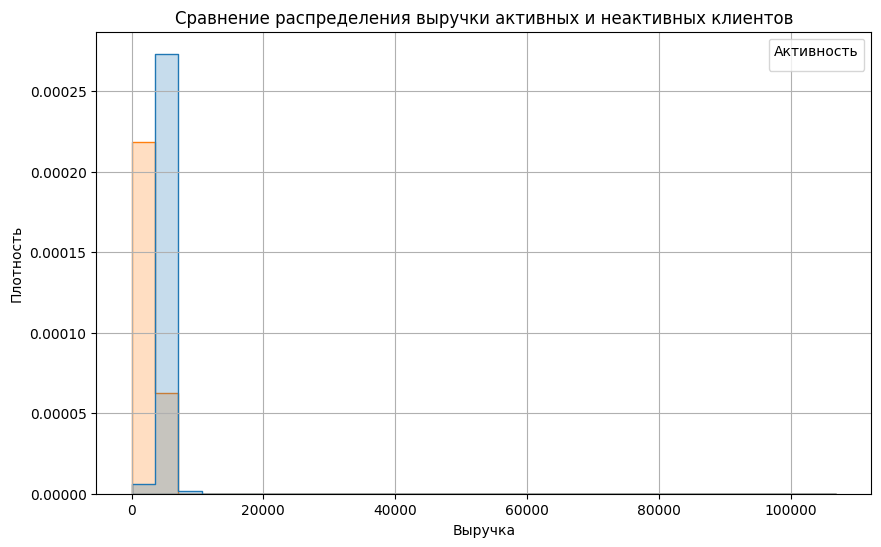

In [42]:
# Преобразование столбца 'Выручка' в числовой тип
market_money['Выручка'] = pd.to_numeric(market_money['Выручка'], errors='coerce')

# Группировка по 'id' и отбор активных клиентов
active_clients = market_money.groupby('id').filter(lambda x: (x['Выручка'] > 0).all())
print("Активные клиенты:")
print(active_clients.head())  # Вывод первых 5 строк активных клиентов

# Определение неактивных клиентов
inactive_clients = market_money[~market_money['id'].isin(active_clients['id'])]
print("Неактивные клиенты:")
print(inactive_clients.head())  # Вывод первых 5 строк неактивных клиентов

# Добавление столбца 'Активность' для последующей визуализации
active_clients['Активность'] = 'активные'
inactive_clients = inactive_clients.assign(Активность='неактивные')

# Объединение активных и неактивных клиентов
combined_clients = pd.concat([active_clients, inactive_clients], ignore_index=True)
print("Объединенные клиенты:")
print(combined_clients[['id', 'Выручка', 'Активность']].head())  # Вывод первых 5 строк объединенного DataFrame

# Построение наложенной гистограммы, если есть данные по неактивным клиентам
if not inactive_clients.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_clients, x='Выручка', hue='Активность', stat='density', bins=30, element='step', common_norm=False)
    
    plt.title('Сравнение распределения выручки активных и неактивных клиентов')
    plt.xlabel('Выручка')
    plt.ylabel('Плотность')
    plt.legend(title='Активность', loc='upper right')
    plt.grid()
    plt.show()
else:
    print("Нет неактивных клиентов для визуализации.")

- Розовые столбики представляют активных клиентов.
- Голубые столбики - неактивных клиентов.

2. Распределение выручки: активные клиенты с выручкой около 0–30000 имеет плотность около 0.00022 - среди активных клиентов значительное количество клиентов с выручкой в этом диапазоне. Активные клиенты с выручкой около 30000–60000 имеют плотность около 0.0007, что указывает на ещё большую концентрацию активных клиентов с выручкой в этом диапазоне.

Неактивные клиенты с выручкой около 0–30000 имеют плотность 0.00002 - среди неактивных клиентов очень мало клиентов с выручкой в этом диапазоне.
Неактивные клиенты с выручкой около 30000–60000 имеют плотность 0.00028, что ниже, чем у активных клиентов, значит активные клиенты с выручкой в этом диапазоне значительно преобладают.
Неактивные клиенты с выручкой около 60000–100000 имеют плотность около 0 - среди неактивных клиентов практически нет клиентов с такой высокой выручкой.

Выводы:
  - Активные клиенты имеют более высокие значения выручки по сравнению с неактивными клиентами, значит они более ценны для бизнеса, так как их выручка выше.
  - Большая плотность активных клиентов в диапазоне 30000–60000 может свидетельствовать о том, что это основной сегмент с высокой выручкой.
  - Неактивные клиенты в основном имеют низкие значения выручки, и их доля среди клиентов с более высокой выручкой практически отсутствует.
  - Неактивные клиенты либо не совершают повторные покупки, либо у них нет интереса к товарам или услугам компании.

Необходимо:
- Улучшение удержания: бизнес может рассмотреть возможность разработки программ лояльности или акций для неактивных клиентов, чтобы вернуть их на уровень активности.
- Сделать фокус на активных клиентах: бизнесу стоит уделить внимание активным клиентам, чтобы сохранить их интерес и увеличить выручку, предлагая персонализированные предложения или услуги.

Описание данных по выручке с учетом периодов:
                      count         mean          std     min      25%  \
Период                                                                   
предыдущий_месяц     1300.0  4936.920385   739.597997     0.0  4496.75   
препредыдущий_месяц  1300.0  4825.206923   405.979663     0.0  4583.00   
текущий_месяц        1300.0  5314.960846  2939.708156  2758.7  4706.05   

                         50%       75%       max  
Период                                            
предыдущий_месяц     5005.00  5405.625    6869.5  
препредыдущий_месяц  4809.00  5053.500    5663.0  
текущий_месяц        5179.95  5761.725  106862.2  


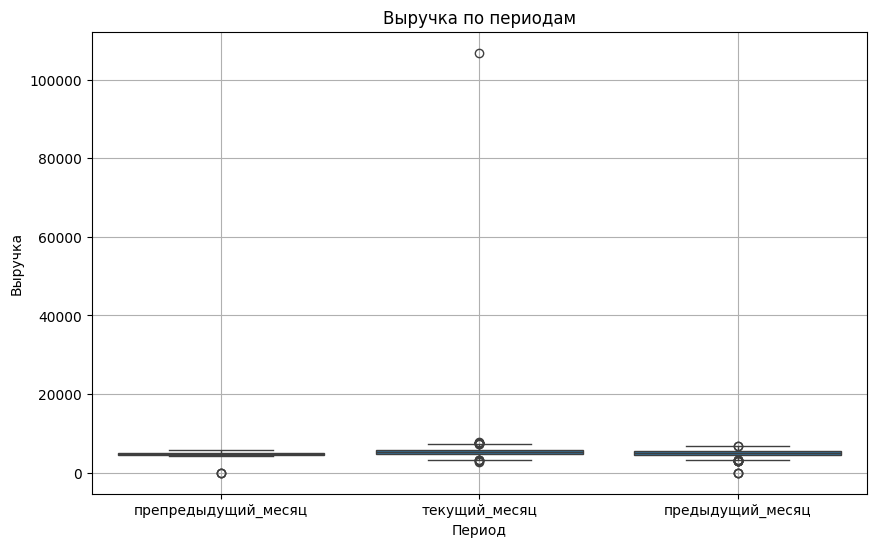

In [43]:
# Определяем числовой тип столбца 'Выручка' 
market_money['Выручка'] = pd.to_numeric(market_money['Выручка'], errors='coerce')

# Описание данных по выручке с учетом периодов
description = market_money.groupby('Период')['Выручка'].describe()

print("Описание данных по выручке с учетом периодов:")
print(description)

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=market_money, x='Период', y='Выручка')
plt.title('Выручка по периодам')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.grid()
plt.xticks(rotation=0)  # Поворачиваем метки по оси X для лучшей читабельности
plt.show()

1.Средняя выручка текущего месяца (5314.96) выше, чем у предыдущих двух месяцев (4936.92 и 4825.21 соответственно), что может указывать на положительный тренд роста выручки.

2.Стандартное отклонение выручки в текущем месяце значительно больше (2939.71), чем в предыдущих двух месяцах (739.60 и 405.98) - большая вариативность значений выручки в этом периоде.

3.Минимальная выручка в текущем месяце (2758.70) также выше, чем минимальные значения для предыдущих двух месяцев (оба равны нулю) - в текущем месяце нет нулевых значений выручки, что является положительным моментом.

4.Максимум выручки в текущем месяце (106862.20) существенно превышает максимумы предыдущих двух месяцев (6869.50 и 5663.00), что указывает на наличие одного или нескольких очень высоких значений выручки, возможно связанных с крупными сделками или событиями или выбросами.

5.Медиана выручки текущего месяца (5179.95) также немного выше медиан предыдущего и препредыдущего месяцев (5005.00 и 4809.00 соответственно).

В целом, данные показывают рост средней выручки и увеличение разброса значений в текущем месяце по сравнению с предыдущими двумя месяцами. Однако значительное стандартное отклонение и аномально высокое максимальное значение могут свидетельствовать о выбросах.
Бизнес генерирует значительную выручку, но выручка может сильно варьироваться в зависимости от периода. Бизнесу следует сосредоточиться на повышении стабильности выручки и увеличении прибыльности менее прибыльных периодов.

In [44]:
# Выявление выбросов в выручке
Q1 = market_money['Выручка'].quantile(0.25)
Q3 = market_money['Выручка'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выбросов
upper_bound = Q3 + 1.5 * IQR

In [45]:
# Обработка выбросов
# Удаляем только аномально высокие значения
market_money = market_money[market_money['Выручка'] <= upper_bound]

In [46]:
# Фильтруем данные для нужных периодов
filtered_data = market_money[market_money['Период'].isin(['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'])]

# Создаем сводную таблицу, где строки - клиенты, а столбцы - периоды
pivot_table = filtered_data.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='sum', fill_value=0)

# Находим клиентов с нулевой выручкой во всех трех периодах
clients_with_zero_revenue = pivot_table[(pivot_table['предыдущий_месяц'] == 0) & 
                                         (pivot_table['препредыдущий_месяц'] == 0) & 
                                         (pivot_table['текущий_месяц'] == 0)]

# Подсчитываем количество таких клиентов
num_clients_with_zero_revenue = clients_with_zero_revenue.shape[0]

print(f"Количество клиентов с нулевой выручкой во всех трех периодах: {num_clients_with_zero_revenue}")

Количество клиентов с нулевой выручкой во всех трех периодах: 0


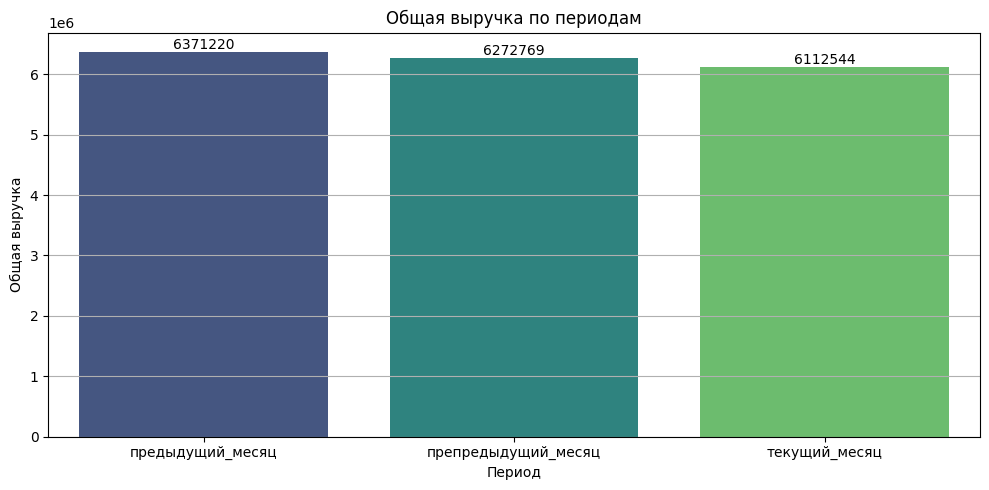

In [47]:
# Группировка данных по периодам для общего анализа
period_summary = market_money.groupby('Период')['Выручка'].sum().reset_index()

# График общей выручки по периодам
plt.figure(figsize=(10, 5))
sns.barplot(data=period_summary, x='Период', y='Выручка', hue='Период', palette='viridis', legend=False)
plt.title('Общая выручка по периодам')
plt.xlabel('Период')
plt.ylabel('Общая выручка')
plt.xticks(rotation=360)
plt.grid(axis='y')
plt.tight_layout()

# Простановка численных значений в диаграмме
for bar in plt.gca().patches:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             '{:.0f}'.format(bar.get_height()),
             ha='center',
             va='bottom')

plt.show()

Данные указывают на отрицательную тенденцию выручки. Средняя выручка в текущем месяце (6034578) ниже, чем в предыдущем месяце (6252136) и препредыдущем месяце (6272779) - снижение средней выручки от месяца к месяцу.

Т.о. бизнес демонстрирует снижение средней выручки с течением времени.

In [48]:
# Отбор клиентов с покупательской активностью не менее трех месяцев
active_clients = market_money.groupby('id').filter(lambda x: (x['Выручка'] > 0).sum() >= 3)

# Выводим отобранных клиентов
print(active_clients)

          id               Период  Выручка
3     215349  препредыдущий_месяц   4472.0
4     215349        текущий_месяц   4971.6
5     215349     предыдущий_месяц   5216.0
6     215350  препредыдущий_месяц   4826.0
7     215350        текущий_месяц   5058.4
...      ...                  ...      ...
3895  216646  препредыдущий_месяц   4725.0
3896  216646     предыдущий_месяц   4923.0
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3

[3585 rows x 3 columns]


Описание данных active_clients по выручке с учетом периодов:
                      count         mean         std     min      25%     50%  \
Период                                                                          
предыдущий_месяц     1195.0  4857.820921  650.185154  2890.0  4462.75  4943.0   
препредыдущий_месяц  1195.0  4834.025105  336.369205  4098.0  4580.50  4802.0   
текущий_месяц        1195.0  5098.507029  704.659291  2758.7  4650.90  5108.4   

                         75%     max  
Период                                
предыдущий_месяц     5308.50  6499.0  
препредыдущий_месяц  5057.00  5663.0  
текущий_месяц        5581.65  6518.4  


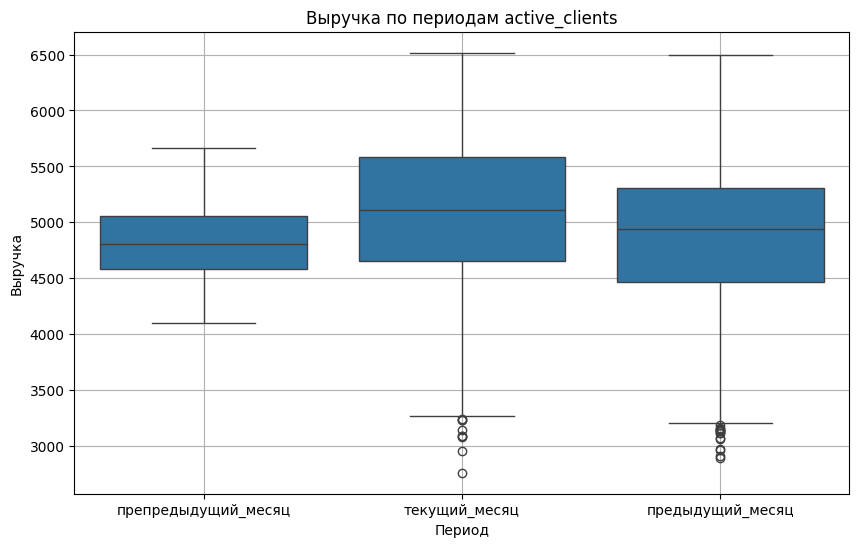

In [49]:
# Определяем числовой тип active_clients столбца 'Выручка' 
active_clients['Выручка'] = pd.to_numeric(active_clients['Выручка'], errors='coerce')

# Описание данных по выручке с учетом периодов
description = active_clients.groupby('Период')['Выручка'].describe()

print("Описание данных active_clients по выручке с учетом периодов:")
print(description)

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=active_clients, x='Период', y='Выручка')
plt.title('Выручка по периодам active_clients')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.grid()
plt.xticks(rotation=0)  # Поворачиваем метки по оси X для лучшей читабельности
plt.show()

1.Средняя выручка active_clients увеличилась от препредыдущего месяца к текущему месяцу. В предыдущем месяце она составляла 4923 рубля, а в текущем – 5156 рублей - положительная динамика среднего дохода от активных клиентов.
  
2.Стандартное отклонение увеличилось от предыдущего месяца к текущему - увеличение разброса значений выручки среди клиентов. Возможно, некоторые клиенты стали приносить больше прибыли, чем раньше, но при этом другие остались на прежнем уровне или даже снизили свою активность.

3.Минимальные значения выручки практически не изменились между всеми тремя периодами - стабильность минимальной активности клиентов.
Максимальная выручка также осталась примерно на одном уровне, однако отмечается небольшое увеличение в текущем месяце до 6518,4 руб., что может говорить о появлении новых крупных клиентов или повышении активности существующих.

4.Квартильные показатели:
   - Медианная выручка (50%) увеличилась незначительно: с 4985,75 до 5149,30 руб., значит половина клиентов приносит доход выше этого уровня.
   - Верхний квартиль (75%) показывает аналогичную тенденцию роста: с 5324,50 до 5603,15 руб. Таким образом, наиболее активные клиенты увеличили свои расходы.

В целом, данные показывают умеренный рост средней выручки и стабильности в минимальных значениях, что является позитивным фактором для бизнеса. Однако увеличение стандартного отклонения требует дополнительного анализа, чтобы понять причины изменений и выявить возможные риски или возможности для дальнейшего улучшения показателей.

Описание данных inactive_clients по выручке с учетом периодов:
                     count         mean          std     min       25%  \
Период                                                                   
предыдущий_месяц      98.0  5776.770408  1054.143382     0.0  5787.125   
препредыдущий_месяц  105.0  4724.847619   865.224546     0.0  4633.000   
текущий_месяц          4.0  4956.950000  1239.721293  3293.1  4374.525   

                        50%       75%     max  
Период                                         
предыдущий_месяц     5928.5  6120.250  6457.0  
препредыдущий_месяц  4864.0  5051.000  5621.0  
текущий_месяц        5274.2  5856.625  5986.3  


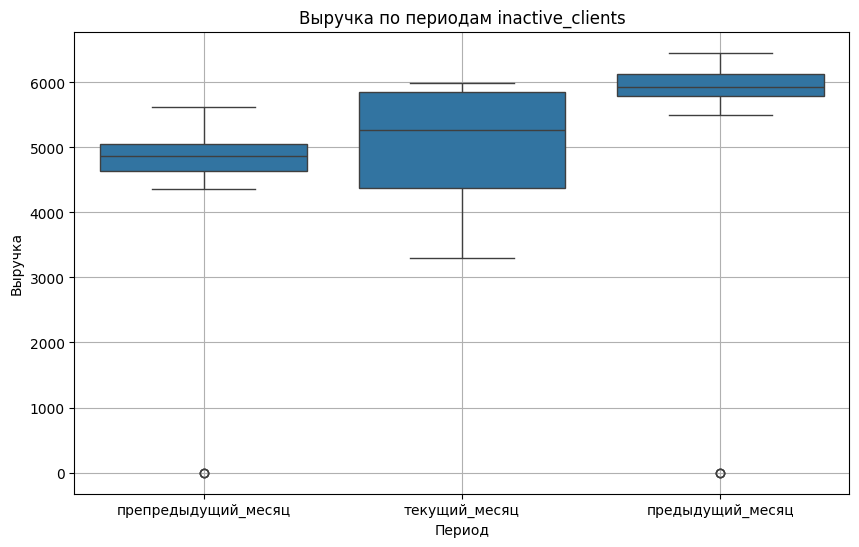

In [50]:
# Определение неактивных клиентов
inactive_clients = market_money[~market_money['id'].isin(active_clients['id'])]

# Определяем числовой тип inactive_clients столбца 'Выручка' 
inactive_clients.loc[:, 'Выручка'] = pd.to_numeric(inactive_clients['Выручка'], errors='coerce')

# Описание данных по выручке с учетом периодов
description = inactive_clients.groupby('Период')['Выручка'].describe()

print("Описание данных inactive_clients по выручке с учетом периодов:")
print(description)

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=inactive_clients, x='Период', y='Выручка')
plt.title('Выручка по периодам inactive_clients')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.grid()
plt.xticks(rotation=0)  # Поворачиваем метки по оси X для лучшей читабельности
plt.show()

Средняя выручка неактивных клиентов снизилась с предыдущего месяца на 23,1% и с препредыдущего месяца на 8,2% - снижение активности неактивных клиентов.
Медианная выручка также снизилась во всех трех периодах: с 5885,5 до 4749,0 и 4367,8 соответственно - половина неактивных клиентов принесла меньше выручки в текущем месяце по сравнению с предыдущими месяцами.
Разброс значений выручки (стандартное отклонение) увеличился с предыдущего месяца, что указывает на растущую неоднородность в активности неактивных клиентов. Некоторые неактивные клиенты стали приносить больше выручки, в то время как другие остались на прежнем уровне или снизили свою активность.
Минимальные и максимальные значения выручки в целом остались стабильными во всех трех периодах - не было существенных изменений в активности самых неактивных и самых активных неактивных клиентов.

В целом, данные указывают на продолжающееся снижение активности неактивных клиентов, что проявляется в снижении средних и медианных значений выручки. Кроме того, наблюдается рост неоднородности в активности неактивных клиентов, что может затруднить разработку эффективных стратегий по их реактивации.

In [51]:
# Определяем числовой тип столбца 'минут' 
market_time['минут'] = pd.to_numeric(market_time['минут'], errors='coerce')

# Описание данных о времени, проведенном на сайте с учетом периодов в таблице market_time
description = market_time.groupby('Период')['минут'].describe()

print("Описание данных времени, проведенного на сайте с учетом периодов:")
display(description)

Описание данных времени, проведенного на сайте с учетом периодов:


,count,mean,std,min,25%,50%,75%,max
Период,,,,,,,,
предыдущий_месяц,1300.0,13.467692,3.932029,5.0,11.0,13.0,17.0,23.0
текущий_месяц,1300.0,13.204615,4.220589,4.0,10.0,13.0,16.0,23.0


1.Средние значения количество наблюдений для обоих периодов близки друг к другу – 13.47 для предыдущего месяца и 13.20 для текущего месяца - за оба периода примерно одинаковое с некоторым снижением в текущем месяце.

2.Стандартное отклонение для текущего месяца немного выше (4.22), чем для предыдущего (3.93) - данные текущего месяца имеют больший разброс относительно среднего значения.

3.Минимальное и максимальное значения для обоих месяцев совпадают (минимум = 4, максимум = 23) - экстремальные значения не изменились от одного месяца к другому.

4.Квартили:
   - Первый квартиль (25%). Для предыдущего месяца он равен 11, а для текущего – 10, значит 25% значений в текущем месяце меньше, чем в предыдущем.
   - Второй квартиль (медиана, 50%). Медианы также схожи – 13 для предыдущего месяца и 13 для текущего - средние значения распределены равномерно вокруг медианы.
   - Третий квартиль (75%) для предыдущего месяца составляет 17, тогда как для текущего – 16, верхняя часть распределения в текущем месяце имеет меньшие значения, чем в предыдущем.

В целом, распределение данных в текущем месяце несколько отличается от предыдущего: наблюдается небольшой сдвиг вниз и увеличение разброса значений, однако общие тенденции остаются похожими, так как минимумы, максимумы и медианы практически не изменились, что требует дальнейшего анализа для определения его причин и разработки стратегий для поддержания или увеличения вовлеченности пользователей. Незначительное снижение среднего времени, проведенного на сайте, в текущем месяце, может быть связано с сезонными факторами, изменениями в контенте сайта или другими факторами, влияющими на поведение пользователей.

Данные показывают, что пользователи тратят значительное количество времени на взаимодействие с сайтом, и большинство пользователей проводят на сайте около среднего времени - сайт привлекательный и интересный для пользователей.

In [52]:
# Описание данных о Прибыли в таблице money
print("Описание Прибыли в таблице money:")
display(money.describe())

Описание Прибыли в таблице money:


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Средняя прибыль на покупателя составляет 3,99 доллара - магазин получает умеренную прибыль от каждого покупателя.
Существует значительная разница между минимальной и максимальной прибылью (0,86 доллара и 7,43 доллара соответственно), значит некоторые покупатели приносят магазину значительно больше прибыли, чем другие.
Медианная прибыль (4,045 доллара) выше среднего значения - большинство покупателей приносят магазину прибыль выше средней.
Распределение прибыли асимметрично, со скосом в сторону более высоких значений прибыли, следовательно у магазина есть несколько очень прибыльных покупателей, которые вносят значительный вклад в общую прибыль.

В целом, данные показывают, что магазин получает прибыль от большинства покупателей, но некоторые покупатели приносят значительно больше прибыли, чем другие. Магазину следует сосредоточиться на привлечении и удержании этих прибыльных покупателей, чтобы увеличить общую прибыль.

Общий вывод: Проведен исследовательский анализ данных из каждой таблицы. Отобраны клиенты с покупательской активностью Снизилась, которые совершали покупки в этот период. Составлен портрет покупателей в этом сегменте, определены наиболее популярные категории в группах Стандарт и Премиум, что позволит провести более точный анализ.
1.Магазину следует сосредоточиться на удержании клиентов с высокой покупательской активностью, а также на привлечении новых клиентов и превращении их в лояльных покупателей. 
2.Бизнесу следует сосредоточиться на повышении стабильности выручки и увеличении прибыльности менее прибыльных периодов.
3.Выявлена положительная тенденция роста выручки. Бизнес демонстрирует устойчивый рост, и средняя выручка увеличивается с течением времени.
4.Пользователи тратят значительное количество времени на взаимодействие с сайтом, и большинство пользователей проводят на сайте около среднего времени. Это говорит о том, что сайт привлекательный и увлекательный для пользователей.
5.Магазин получает прибыль от большинства покупателей, но некоторые покупатели приносят значительно больше прибыли, чем другие. Магазину следует сосредоточиться на привлечении и удержании этих прибыльных покупателей, чтобы увеличить общую прибыль.

Клиенты Стандарт и Премиум со снижающейся покупательской активностью имеют схожие интересы в популярных категориях, таких как "Товары для детей" и "Домашний текстиль". Однако группа Премиум отличается более высоким спросом на "Косметику и аксессуары". Обе группы проявляют интерес к функциональным товарам, таким как "Кухонная посуда" и "Техника для красоты", а также к "Мелкой электронике".
Несмотря на сходство в предпочтениях, снижение активности указывает на необходимость улучшения клиентского опыта и более целенаправленных маркетинговых акций. 

Признаки, характерные для клиентов со снижающейся активностью, совершавших покупки не менее трех месяцев:

-Снижение частоты и объема покупок;
-Повышение стандартного отклонения в выручке;
-Уменьшение медианной выручки;
-Снижение верхнего квартиля выручки.

Шаг 4. Объединение таблиц

-Объедините таблицы market_file.csv, market_money.csv, market_time.csv. 
-Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 
-Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. 
-В итоговой таблице сделайте отдельный столбец для каждого периода.

In [53]:
display(market_file.head(10))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [54]:
display(market_money.head(10))

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
10,215351,предыдущий_месяц,6158.0


In [55]:
display(market_time.head(10))

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдущий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдущий_месяц,8


In [56]:
# Разворачиваем таблицы с периодами
market_money_wide = market_money.pivot_table(index='id', columns='Период', values='Выручка')
market_time_wide = market_time.pivot_table(index='id', columns='Период', values='минут')

# Фильтруем активных пользователей
active_users = market_money_wide.loc[~(market_money_wide == 0).any(axis=1)].index

# Объединяем таблицы
joined_data = pd.merge(market_file[market_file['id'].isin(active_users)],
                       market_money_wide, on='id', how='inner').merge(market_time_wide, on='id', how='inner')

joined_data = joined_data.loc[:, (joined_data != 0).any(axis=0)]  # Убираем признаки со всеми нулями в выручке

# Выводим результат
display(joined_data)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,NaN,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,7.0
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.0
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,18.0
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,7.0


In [57]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

В результате получилась таблица с 1068 строками. Количество колонок - 18.

In [58]:
joined_data = joined_data.rename(columns={
    "предыдущий_месяц_x": "предыдущий_месяц_Выручка",
    "препредыдущий_месяц": "препредыдущий_месяц_Выручка",
    "текущий_месяц_x": "текущий_месяц_Выручка",
    "предыдущий_месяц_y": "предыдущий_месяц_мин",
    "текущий_месяц_y": "текущий_месяц_мин"
})

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

Шаг 5. Корреляционный анализ

-Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 
-Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

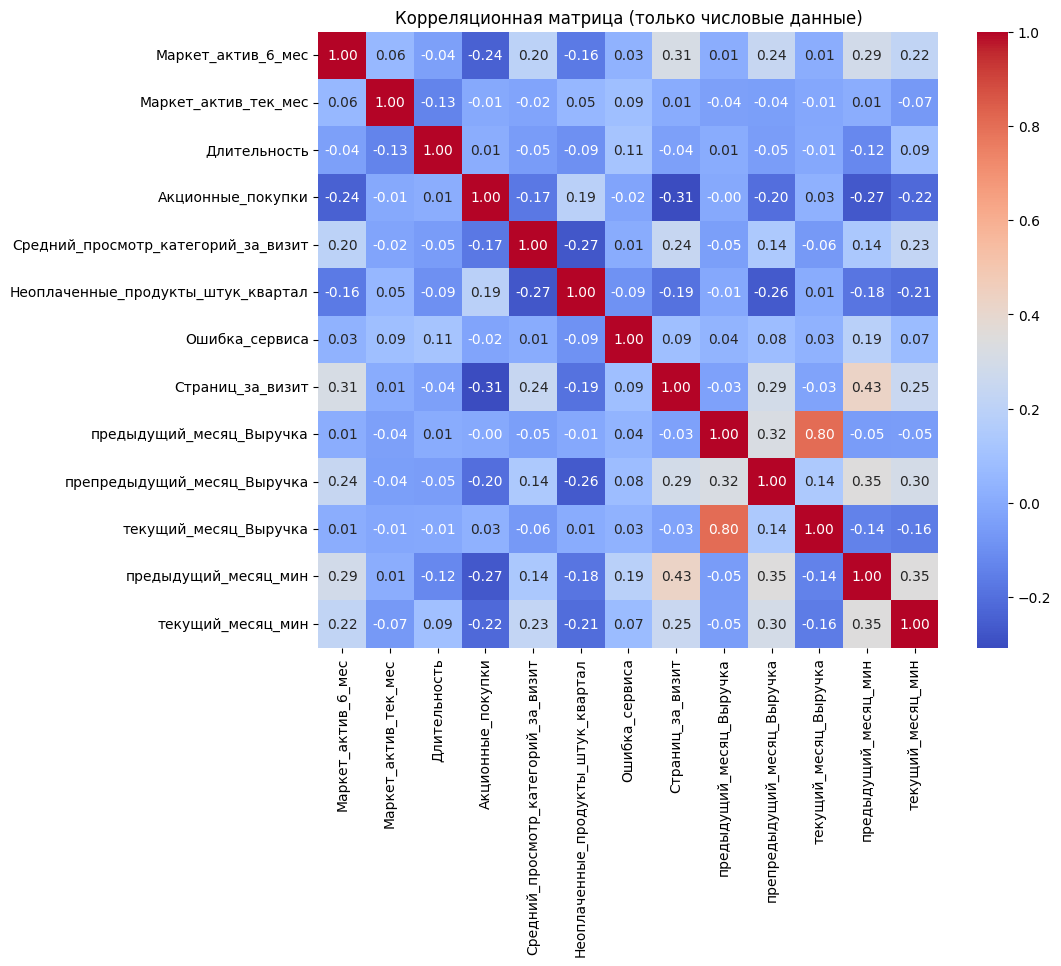

In [59]:
# Выбираем только числовые столбцы для корреляции
numeric_data = joined_data.select_dtypes(include=['number']).drop('id', axis=1, errors='ignore')
corr_matrix = numeric_data.corr()

# Визуализация тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица (только числовые данные)')
plt.show()

Положительные корреляции:
1.Текущий месяц Выручка и предыдущий месяц Выручка (0.807824), Предыдущий месяц Выручка и препредыдущий месяц Выручка (0.343387) - выручка нарастает от месяца к месяцу, пользователи, которые проводили больше времени в предыдущем месяце, скорее всего, будут также активны в текущем месяце.
2.Неоплаченные_продукты_штук_квартал и Акционные_покупки (0.225608) - пользователи, имеющие неоплаченные продукты, склонны к акционным покупкам.

Отрицательные корреляции:
1.Акционные_покупки и Страниц_за_визит (-0.320161) - пользователи, которые совершают акционные покупки, просматривают меньше страниц за визит.

2.текущий_месяц_Выручка и Акционные_покупки (-0.270930) - акционные покупки не способствуют увеличению выручки в текущем месяце.

Переменные Длительность, Ошибка_сервиса, и Неоплаченные_продукты_штук_квартал имеют слабые связи с другими переменными, что может указывать на их низкое влияние на выручку или поведение пользователей.

Необходимо анализировать поведение пользователей с высокой выручкой, т.к. существует сильная корреляция между выручкой в разные месяцы, чтобы выявить факторы успеха.
Учитывая отрицательную корреляцию между акционными покупками и общей выручкой, стоит пересмотреть стратегии акций и предложений для повышения их эффективности.
Улучшить пользовательский опыт, взаимодействие пользователей с платформой для увеличения времени, проведенного на сайте.

In [60]:
# Выбираем только числовые столбцы
numeric_data = joined_data.select_dtypes(include=['number'])

# Строим корреляционную матрицу
corr_matrix = numeric_data.corr(method='spearman')
corr_matrix.style.background_gradient(cmap="RdYlGn")

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
id,1.000000,0.341026,-0.006258,-0.061987,-0.379846,0.280582,-0.257080,0.099014,0.527716,-0.071800,0.341086,-0.072231,0.486874,0.433170
Маркет_актив_6_мес,0.341026,1.000000,0.061697,-0.044614,-0.277968,0.185027,-0.134368,0.038656,0.319918,-0.007625,0.233325,0.003573,0.274003,0.226345
Маркет_актив_тек_мес,-0.006258,0.061697,1.000000,-0.131979,0.033045,-0.025158,0.061754,0.087351,0.003144,-0.031169,-0.039397,-0.006993,0.013538,-0.063044
Длительность,-0.061987,-0.044614,-0.131979,1.000000,0.029186,-0.043150,-0.108822,0.103528,-0.034591,0.011269,-0.039284,-0.005248,-0.124000,0.083035
Акционные_покупки,-0.379846,-0.277968,0.033045,0.029186,1.000000,-0.203380,0.197624,-0.051590,-0.370853,0.003793,-0.267790,0.023905,-0.332743,-0.274693
Средний_просмотр_категорий_за_визит,0.280582,0.185027,-0.025158,-0.043150,-0.203380,1.000000,-0.251448,0.010034,0.267536,-0.053747,0.149619,-0.062342,0.148376,0.233358
Неоплаченные_продукты_штук_квартал,-0.257080,-0.134368,0.061754,-0.108822,0.197624,-0.251448,1.000000,-0.098544,-0.165297,0.032997,-0.249421,0.034695,-0.183426,-0.214803
Ошибка_сервиса,0.099014,0.038656,0.087351,0.103528,-0.051590,0.010034,-0.098544,1.000000,0.104508,0.033150,0.090105,0.035881,0.196017,0.078089
Страниц_за_визит,0.527716,0.319918,0.003144,-0.034591,-0.370853,0.267536,-0.165297,0.104508,1.000000,-0.064438,0.311428,-0.050390,0.450913,0.298113
предыдущий_месяц_Выручка,-0.071800,-0.007625,-0.031169,0.011269,0.003793,-0.053747,0.032997,0.033150,-0.064438,1.000000,0.304969,0.852853,-0.075934,-0.079382


Тепловая карта визуализирует степень корреляции между признаками. Чем более красный цвет, тем сильнее положительная корреляция, а чем более зеленый цвет, тем сильнее отрицательная корреляция. Признаки с высокой корреляцией (близкой к 1 или -1) могут быть потенциально проблематичными.

Мультиколлинеарность - пары признаков, которые имеют корреляцию выше заданного порога (например, 0.7), значит эти признаки могут быть избыточными, и один из них может быть удален без потери информации. 

Признаки текущий_месяц_Выручка и предыдущий_месяц_Выручка имеют коэффициент корреляции 0,8396, что указывает на сильную мультиколлинеарность. Это означает, что эти признаки содержат избыточную информацию и могут быть взаимозаменяемы в модели.

Для устранения мультиколлинеарности можно исключить один из признаков.

In [61]:
# Анализ мультиколлинеарности
threshold = 0.7  # Порог для выявления мультиколлинеарности
multicollinearity_pairs = []

# Проверка на мультиколлинеарность
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            multicollinearity_pairs.append((corr_matrix.columns[i], 
                                            corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Вывод пар с высокой корреляцией
if multicollinearity_pairs:
    print("Обнаружены пары признаков с высокой корреляцией (мультиколлинеарность):")
    for pair in multicollinearity_pairs:
        print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")
else:
    print("Мультиколлинеарность не обнаружена.")

Обнаружены пары признаков с высокой корреляцией (мультиколлинеарность):
текущий_месяц_Выручка и предыдущий_месяц_Выручка: корреляция = 0.85


Коэффициенты корреляции между признаками стали ниже, что свидетельствует об устранении избыточной информации.
Признаки по-прежнему имеют как положительные, так и отрицательные корреляции, что указывает на наличие как прямых, так и обратных зависимостей между ними.

Самая сильная положительная корреляция наблюдается между Маркет_актив_6_мес и Маркет_актив_тек_мес (0,3551), значит более высокая активность в течение последних шести месяцев влияет на более высокую активностью в текущем месяце.

Самая сильная отрицательная корреляция наблюдается между Средний_просмотр_категорий_за_визит и Неоплаченные_продукты_штук_квартал (-0,2746), значит более высокий уровень среднего просмотра категорий связан с меньшим количеством неоплаченных продуктов.

Корреляции полезны для понимания поведения клиентов и выявления потенциальных факторов, влияющих на доход.

Шаг 6. Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.
6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.
6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.
6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
•	использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
•	использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [62]:
# Выведем информацию о данных
print(joined_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

In [63]:
# Создать маску пропущенных значений
mask = joined_data.isnull().any(axis=1)

# Отобразить строки с пропущенными значениями
display(joined_data[mask])

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,NaN,11.0,13.0
20,215371,Снизилась,стандарт,да,3.8,4,365,0.21,Домашний текстиль,5,0,6,1,NaN,4742.0,NaN,10.0,10.0
29,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,6077.0,5051.0,NaN,12.0,14.0
34,215385,Снизилась,стандарт,да,3.6,4,721,0.24,Домашний текстиль,5,3,4,4,6184.5,4707.0,NaN,10.0,8.0
45,215396,Снизилась,стандарт,да,3.4,5,706,0.22,Домашний текстиль,2,3,8,4,5876.0,4805.0,NaN,12.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,216508,Прежний уровень,стандарт,да,4.9,5,384,0.28,Техника для красоты и здоровья,6,0,3,8,NaN,5553.0,5813.4,12.0,14.0
1190,216541,Прежний уровень,стандарт,да,4.1,4,593,0.29,Косметика и аксесуары,4,1,1,8,5782.0,4432.0,NaN,18.0,22.0
1201,216552,Прежний уровень,стандарт,да,4.9,4,922,0.28,Товары для детей,6,7,5,9,5700.5,4460.0,NaN,9.0,16.0
1203,216554,Прежний уровень,премиум,да,5.1,4,893,0.12,Кухонная посуда,2,4,4,9,6205.5,5307.0,NaN,17.0,11.0


In [64]:
# Удалить строки с пропущенными значениями
joined_data = joined_data.dropna()

# Выведем информацию о данных
display(joined_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1195 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1195 non-null   int64  
 1   Покупательская активность            1195 non-null   object 
 2   Тип сервиса                          1195 non-null   object 
 3   Разрешить сообщать                   1195 non-null   object 
 4   Маркет_актив_6_мес                   1195 non-null   float64
 5   Маркет_актив_тек_мес                 1195 non-null   int64  
 6   Длительность                         1195 non-null   int64  
 7   Акционные_покупки                    1195 non-null   float64
 8   Популярная_категория                 1195 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1195 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1195 non-null   int64  
 11  Ошибка_сервиса                     

None

In [65]:
# Отберем клиентов с покупательской активностью "Снизилась"
inactive_customers = joined_data[joined_data['Покупательская активность'] == 'Снизилась']

# Отберем количество клиентов с типом сервиса 'Премиум'
num_premium = inactive_customers[inactive_customers['Тип сервиса'] == 'премиум'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Премиум'
premium_inactive = inactive_customers[inactive_customers['Тип сервиса'] == 'премиум']
display(premium_inactive.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9.0,6.0
11,215362,Снизилась,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13.0,13.0
13,215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11.0,9.0
16,215367,Снизилась,премиум,да,4.2,4,581,0.40,Товары для детей,5,1,4,1,5164.5,4668.0,5493.4,8.0,7.0


In [66]:
display(premium_inactive.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,215596.013158,3.624342,3.986842,725.414474,0.462039,2.519737,3.677632,4.210526,5.651316,4922.246711,4670.217105,5233.844737,10.361842,10.644737
std,161.780367,1.012112,0.736799,222.110928,0.304573,1.079431,2.309216,2.008695,3.032407,742.145750,242.563678,756.744016,3.461327,3.320432
min,215349.000000,0.900000,3.000000,187.000000,0.110000,1.000000,0.000000,1.000000,1.000000,2909.000000,4119.000000,2758.700000,5.000000,4.000000
25%,215456.500000,3.075000,3.000000,553.000000,0.240000,2.000000,2.000000,3.000000,4.000000,4542.250000,4500.000000,4709.100000,8.000000,9.000000
50%,215578.000000,3.900000,4.000000,761.500000,0.320000,3.000000,3.000000,4.000000,5.000000,5050.000000,4668.000000,5235.750000,10.000000,10.000000
75%,215708.500000,4.200000,5.000000,894.750000,0.892500,3.000000,5.000000,6.000000,7.000000,5403.625000,4838.250000,5847.675000,12.000000,13.000000
max,215940.000000,5.700000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,17.000000,6314.500000,5555.000000,6457.800000,23.000000,21.000000


# premium_inactive

1. Маркетинговая активность - число рассылок, звонков, показов рекламы и прочего, которое приходилось на клиента за последние 6 месяцев - 3,62 - относительно высокая постоянная активность, в текущем месяце среднее значение повысилось до 3.96 - компания наращивает ресурс на привлечение.

2. Длительность со дня регистрации клиентов на сайте компании 725 дней (примерно 2г), в основном постоянные клиенты теряют интерес.

3. Акционные покупки - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев - 0.462 - около половины клиентов все еще заинтересованы в акциях.

4. Средний просмотр категорий за визит 2,52 - клиенты просматривают немного более 2 категории за визит - умеренный интерес или сложность навигации на сайте.

5. Среднее количество неоплаченных продуктов составляет 3,68 за квартал - клиенты оставляют товары в корзине, но не завершают покупку (высокая цена или отсутствие уверенности в качестве товара).

6. Среднее значение ошибок сервиса - 4.21 - существующие проблемы в системе, которые могут негативно влиять на опыт пользователей и их желание совершать покупки.

7. Среднее количество страниц, просматриваемых за визит - 5.65 - при определенном интересе клиенты все же исследуют сайт, но, возможно, не находят то, что им нужно.

8. Выручка по месяцам составляет в среднем 4670.21, 4922.25, а за текущий месяц — 5233.84 - небольшое увеличение выручки, несмотря на снижение активности, значит оставшиеся активные клиенты совершают более крупные покупки.

9. Средние значения минут за визит составляют 10,6 и 10,64 минут соответственно, - самый низкий интерес и вовлеченность или сложность навигации.

Необходимо: 
-улучшить навигацию и функциональные возможности сайта, чтобы повысить вовлеченность клиентов.
-предложить специальные акции или напоминания для клиентов, оставляющих товары в корзине, чтобы увеличить конверсию.
-устранить проблемы, которые могут вызывать недовольство пользователей, что улучшит их общее впечатление от покупок.
-увеличить число акционных предложений может привести к повышению интереса со стороны клиентов.

In [67]:
# Отберем клиентов с покупательской активностью "Снизилась"
inactive_customers = joined_data[joined_data['Покупательская активность'] == 'Снизилась']

# Отберем количество клиентов с типом сервиса 'Стандарт'
num_premium = inactive_customers[inactive_customers['Тип сервиса'] == 'стандарт'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Стандарт'
standart_inactive = inactive_customers[inactive_customers['Тип сервиса'] == 'стандарт']
display(standart_inactive.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11.0,12.0
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12.0,10.0


In [68]:
display(standart_inactive.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,215623.571906,3.819398,4.026756,560.491639,0.449732,2.648829,3.762542,3.709030,5.521739,4829.045151,4666.969900,5107.888963,11.270903,11.220736
std,168.766142,1.055105,0.689777,230.927360,0.305319,1.305804,2.309987,1.802018,3.695003,756.131283,314.147172,778.370094,3.539355,3.544270
min,215350.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,1.000000,1.000000,2890.000000,4098.000000,3078.300000,5.000000,4.000000
25%,215482.000000,3.300000,4.000000,373.000000,0.240000,2.000000,2.000000,2.000000,3.000000,4398.500000,4440.000000,4554.700000,9.000000,9.000000
50%,215616.000000,3.900000,4.000000,566.000000,0.300000,2.000000,4.000000,3.000000,4.000000,4955.000000,4652.000000,5156.600000,11.000000,11.000000
75%,215735.000000,4.400000,4.500000,730.500000,0.890000,3.000000,5.000000,5.000000,7.000000,5347.000000,4832.000000,5721.450000,13.000000,13.000000
max,215941.000000,6.600000,5.000000,1064.000000,0.990000,6.000000,10.000000,8.000000,18.000000,6400.000000,5601.000000,6510.900000,23.000000,22.000000


# standart_inactive
1. Маркетинговая активность за последние 6 месяцев составляет 3.81 - стабильная активность компании в этом сегменте, однако в текущем месяце среднее значение маркетинговой активности не увеличилось - 3.82, что может свидетельствовать о небольшом интересе компании в этой категории.

2. Длительность со дня регистрации клиентов на сайте компании 560.49 дней - стаж клиентов меньше, чем premium_inactive - недостаточное вовлечение.

3. Среднее количество акционных покупок составляет 0.449 - немного ниже премиум клиентов, значит стандарт клиенты менее активно ищут или менее заинтересованы в акциях.

4. Средний просмотр категорий за визит - 2.64 - клиенты просматривают более 2 категорий за визит - интерес к различным категориям товаров, примерно такой же как и в премиум классе.

5. Среднее количество неоплаченных продуктов составляет 3.76 за квартал - клиенты оставляют товары в корзине или добавляют их в список желаемого, но не завершают покупки немного выше, чем премиум.

6. Среднее значение ошибок сервиса - 3.70 - меньше, чем в премиум классе, но потенциальные проблемы с работой сервиса также могут негативно сказываться на клиентском опыте.

7. Среднее количество страниц, просматриваемых за визит, составляет 5.52 - ниже премиум - клиенты исследуют сайт, но, вероятно, не находят то, что им нужно.

8. Выручка по месяцам составляет в среднем 4666.96, 4829.05, а за текущий месяц — 5107.89 (ниже премиум сегмента), хотя показывают небольшое увеличение выручки, даже при низкой активности - возможно совершают более крупные покупки.

9. Средние значения минут за визит составляют 11.27 и 11.22 минут соответственно, что указывает на небольшой интерес и вовлеченность, но немного больший, чем premium_inactive.

In [69]:
# Отберем клиентов с покупательской активностью "Прежний уровень"
active_customers = joined_data[joined_data['Покупательская активность'] == 'Прежний уровень']

# Отберем количество клиентов с типом сервиса 'Премиум'
num_premium = active_customers[active_customers['Тип сервиса'] == 'премиум'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Премиум'
premium_active = active_customers[active_customers['Тип сервиса'] == 'премиум']
display(premium_active.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
398,215749,Прежний уровень,премиум,да,5.8,5,624,0.30,Техника для красоты и здоровья,4,3,6,14,5190.0,4928.0,5092.5,14.0,17.0
402,215753,Прежний уровень,премиум,да,5.5,5,191,0.17,Косметика и аксесуары,6,0,4,8,4395.5,4808.0,4168.0,15.0,15.0
403,215754,Прежний уровень,премиум,да,4.6,3,937,0.14,Домашний текстиль,5,2,4,14,5493.0,4752.0,6265.2,7.0,12.0
408,215759,Прежний уровень,премиум,да,3.6,5,589,0.21,Кухонная посуда,3,1,4,6,5215.0,5329.0,5246.2,20.0,12.0
409,215760,Прежний уровень,премиум,да,3.3,3,949,0.24,Техника для красоты и здоровья,3,2,4,6,4989.0,5089.0,5206.1,14.0,14.0


In [70]:
display(premium_active.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,216240.315508,4.493048,3.887701,720.855615,0.230856,3.411765,2.422460,4.256684,10.641711,4865.941176,4940.245989,4999.875936,14.989305,15.668449
std,245.096891,0.802754,0.720818,243.423026,0.146557,1.234134,1.516266,2.099256,3.478810,563.860822,321.802256,718.014593,3.456316,3.850320
min,215749.000000,2.400000,3.000000,150.000000,0.110000,1.000000,0.000000,0.000000,3.000000,3155.000000,4339.000000,3227.000000,7.000000,5.000000
25%,216060.500000,4.000000,3.000000,569.000000,0.150000,2.500000,1.000000,3.000000,8.000000,4449.250000,4681.000000,4535.750000,13.000000,13.000000
50%,216259.000000,4.400000,4.000000,763.000000,0.210000,3.000000,2.000000,4.000000,11.000000,4904.000000,4908.000000,5004.000000,15.000000,16.000000
75%,216434.500000,5.150000,4.000000,920.000000,0.260000,4.000000,4.000000,6.000000,13.000000,5299.000000,5178.500000,5459.700000,18.000000,18.000000
max,216647.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,6.000000,9.000000,20.000000,6109.000000,5653.000000,6517.800000,22.000000,23.000000


# premium_active

1. Маркетинговая активность - число рассылок, звонков, показов рекламы и прочего, которое приходилось на клиента за последние 6 месяцев - 4.49 - высокая и выше в этом сегменте. В текущем месяце средний показатель маркетинговой активности составляет 3,89, что говорит о снижении активности компании по сравнению с premium_inactive и неэффективности политики компании в этой категории.

2. Длительность со дня регистрации клиентов на сайте компании 720.85 дней (немного ниже, чем у premium_inactive) - клиенты премиум сегмента в основном постоянные с длительным стажем.

3. Среднее количество акционных покупок составляет 0,23 вдвое меньше, чем  premium_inactive и standart_inactive, что свидетельствует о небольшом интересе к акциям - клиенты готовы тратить.

4. Средний просмотр категорий за визит 3,41 - больше категорий за визит, чем premium_inactive и standart_inactive, высокий интерес к разнообразию товаров, либо высокий уровнь удовлетворенности текущими предложениями.

5. Среднее количество неоплаченных продуктов - 2,42 за квартал - гораздо меньше premium_active не завершили покупки по сравнению с premium_inactive, либо активно используют корзины для планирования будущих покупок.

6. Среднее количество ошибок сервиса равно 4,25 - сопоставимо с premium_inactive, клиенты сталкиваются с проблемами сайта, несмотря на то, что являются постоянными пользователями.

7. Среднее количество страниц, просматриваемых за визит, составляет 10.64 - вдвое больше, чем premium_inactive - высокий уровень вовлеченности, клиенты тщательно исследуют доступные предложения.

8. Выручка по месяцам составляет в среднем 4940.24, 4865.94, а за текущий месяц — 4999.88 - стабильный рост выручки, но рост меньше, чем в сегменте premium_inactive. Это может указывать на неуспешные маркетинговые стратегии, которые привлекают клиентов.

9. Средние значения минут за визит составляют 14.98 и 15.66 минут соответственно, что указывает на существенный рост вовлеченности самый высокий среди всех категорий и/или сложность навигации.

Возможно стоит рассмотреть улучшение акционных предложений и маркетинговой активности для привлечения и удержания большего числа клиентов.
Необходимо проведение анализа неполных покупок и разработка стратегий по возвращению клиентов для завершения покупок.
Чтобы поддерживать высокий уровень обслуживания и решить проблемы поддержания доверия клиентов, возможно нужны персонифицированные предложения.

In [71]:
# Отберем клиентов с покупательской активностью "Прежний уровень"
active_customers = joined_data[joined_data['Покупательская активность'] == 'Прежний уровень']

# Отберем количество клиентов с типом сервиса 'Стандарт'
num_premium = active_customers[active_customers['Тип сервиса'] == 'стандарт'].shape[0]

# Выведем информацию о данных клиентах с типом сервиса 'Стандарт'
standart_active = active_customers[active_customers['Тип сервиса'] == 'стандарт']
display(standart_active.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
397,215748,Прежний уровень,стандарт,нет,4.3,4,534,0.18,Кухонная посуда,3,1,4,10,5083.0,4552.0,5673.2,13.0,13.0
399,215750,Прежний уровень,стандарт,да,4.8,5,634,0.21,Товары для детей,4,5,3,10,3319.0,4730.0,4672.3,13.0,14.0
400,215751,Прежний уровень,стандарт,да,4.1,4,957,0.17,Техника для красоты и здоровья,5,2,6,9,5340.0,4769.0,5021.5,14.0,12.0
401,215752,Прежний уровень,стандарт,нет,4.0,4,475,0.30,Мелкая бытовая техника и электроника,3,3,7,7,5188.5,4635.0,5798.2,13.0,8.0
404,215755,Прежний уровень,стандарт,да,4.4,4,216,0.18,Техника для красоты и здоровья,2,3,5,13,4000.0,4814.0,4835.9,19.0,7.0


In [72]:
display(standart_active.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_Выручка,препредыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_мин,текущий_месяц_мин
count,557.00000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,216246.10772,4.581329,4.050269,546.658887,0.242747,3.784560,2.197487,4.393178,9.531418,4852.960503,4932.741472,5089.651526,15.111311,14.312388
std,247.11104,0.859507,0.676683,244.925511,0.168506,1.285046,1.498366,1.948479,3.337357,586.366520,321.804564,636.553830,3.349836,4.007557
min,215748.00000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000,2970.000000,4338.000000,2952.200000,7.000000,4.000000
25%,216048.00000,4.000000,4.000000,348.000000,0.160000,3.000000,1.000000,3.000000,7.000000,4490.500000,4683.000000,4733.600000,13.000000,12.000000
50%,216256.00000,4.400000,4.000000,522.000000,0.210000,4.000000,2.000000,4.000000,9.000000,4927.000000,4935.000000,5088.100000,15.000000,14.000000
75%,216460.00000,5.300000,5.000000,749.000000,0.260000,5.000000,3.000000,6.000000,12.000000,5276.500000,5173.000000,5482.700000,18.000000,17.000000
max,216646.00000,6.600000,5.000000,1052.000000,0.990000,6.000000,8.000000,9.000000,19.000000,6499.000000,5663.000000,6518.400000,23.000000,23.000000


# standart_active
1. Маркетинговая активность за последние 6 месяцев составляет 4,58 - высокая и выше в этом сегменте, чем standart_inactive, но ниже, чем premium_active. В текущем месяце средний показатель маркетинговой активности составляет 4,05. - компания проявляет повышенную активность в течение шести месяцев и текущего месяца, но снизила ее на настоящее время.

2. Длительность со дня регистрации клиентов на сайте компании около 546.65 дней - стаж клиентов немного меньше standart_inactive, но сопоситавимо и существенно отличается по сравнению с premium. Значит компания ориентирована в основном на premium сегмент и его удержание.

3. Акционные покупки - примерно 0.24 - менее четверти покупок совершаются по акциям. Стандартное отклонение небольшое (0.17), поэтому можно предположить, что уровень участия в акциях относительно стабилен.

4. Средний просмотр категорий за визит - около 3.78 категорий. Разброс также невелик (стандартное отклонение 1.29), что говорит о стабильном поведении большинства клиентов при просмотре различных категорий товаров.

5. Неоплаченные продукты штук квартал - среднее значение 2.20 (самое низкое по сравнению с другими категориями) - в среднем у каждого клиента остается неоплаченными два продукта за квартал. Возможно ассортимент сайта более предпочтителен в качественном и в ценовом уровне для этой категории. Стандартное отклонение достаточно высокое (1.50), что свидетельствует о значительных различиях между клиентами в этом показателе.

6. Среднее значение ошибки сервиса составляет 4.39, а максимальное – 9. Это может указывать на наличие ошибок в работе сервиса, однако среднее значение находится ближе к минимальному, чем к максимальному, что говорит о частых случаях отсутствия ошибок.

7. Клиенты в среднем посещают около 9.53 страниц за визит - существенно выше, чем чем standart_inactive, но ниже premium_active. Стандартное отклонение довольно большое (3.34), что указывает на значительные различия в количестве посещаемых страниц разными пользователями.

8. Доходность за предыдущие месяцы имеет средние значения около 4933, 4853 рублей соответственно, тогда как текущий месяц приносит чуть больше дохода (около 5090 рублей). Стандартные отклонения небольшие, что говорит об относительной стабильности доходов от месяца к месяцу и выше, чем premium_active.

9. Средние значения минут за визит составляют 15.11 и 14.31 минут соответственно - снижение активности и интереса в средней длительности визита в прошлом и текущем месяце по сравнению с premium_active.

Подготовка данных и обучения модели.

In [73]:
# Преобразуем целевой признак в категориальный тип
le = LabelEncoder()
joined_data['Покупательская активность'] = le.fit_transform(joined_data['Покупательская активность'])

# Определяем целевую переменную и признаки
y = joined_data['Покупательская активность']
X = joined_data.drop(['id'], axis=1)
X = X.drop(['Покупательская активность'], axis=1)

In [74]:
# Разделение данных на обучающую и тестовую выборки
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [75]:
# Обработка категориальных признаков
categorical_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Тип сервиса', 'Разрешить сообщать', 
                                                                          'Популярная_категория'])
    ]
)

In [76]:
# Пайплайн для обработки количественных признаков
numerical_transformer = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), 
         ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
          'Средний_просмотр_категорий_за_визит', 
          'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 
          'предыдущий_месяц_Выручка', 'препредыдущий_месяц_Выручка', 'текущий_месяц_Выручка', 
          'предыдущий_месяц_мин', 'текущий_месяц_мин'])
    ]
)

In [77]:
# Пайплайн для объединения пайплайнов обработки категориальных и количественных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, ['Тип сервиса', 
                                                  'Разрешить сообщать', 'Популярная_категория']),
        ('numerical', numerical_transformer, ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                                              'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                                              'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                                              'Страниц_за_визит', 'предыдущий_месяц_Выручка', 
                                              'препредыдущий_месяц_Выручка', 'текущий_месяц_Выручка', 
                                              'предыдущий_месяц_мин', 'текущий_месяц_мин'])
    ]
)

In [78]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,      # Увеличили количество деревьев с дефолтных 100 до 200
        max_depth=10,          # Ограничили глубину деревьев
        min_samples_split=5,   # Минимальное число samples для разделения узла
        random_state=RANDOM_STATE
    ))                         
])                             

# Обучение модели
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  ColumnTransformer(transformers=[('onehot',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 handle_unknown='ignore'),
                                                                                   ['Тип '
                                                                                    'сервиса',
                                                                                    'Разрешить '
                                                                                    'сообщать',
                                                                                    'Популярная_категория'])]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('numerical',
                                                  ColumnTransformer(transformers=[('standa...
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'предыдущий_месяц_Выручка',
                                                   'препредыдущий_месяц_Выручка',
                                                   'текущий_месяц_Выручка',
                                                   'предыдущий_месяц_мин',
                                                   'текущий_месяц_мин'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

In [79]:
# Оценка модели 
print("Accuracy on training set:", pipeline.score(X_train, y_train)) 
print("Accuracy on test set:", pipeline.score(X_test, y_test))

Accuracy on training set: 0.9539748953974896
Accuracy on test set: 0.9079497907949791


In [80]:
print(f"Размер X_train: {X_train.shape}, Размер y_train: {y_train.shape}")

Размер X_train: (956, 16), Размер y_train: (956,)


In [81]:
# Проверка уникальных классов
unique_classes = np.unique(y_train)
num_unique_classes = len(unique_classes)

print(f"Уникальные классы в y_train: {unique_classes}")
print(f"Количество уникальных классов: {num_unique_classes}")

Уникальные классы в y_train: [0 1]
Количество уникальных классов: 2


In [82]:
# Преобразование целевой переменной
le = LabelEncoder()
joined_data['Покупательская активность'] = le.fit_transform(joined_data['Покупательская активность'])

# Разделение данных
y = joined_data['Покупательская активность']
X = joined_data.drop(['id', 'Покупательская активность'], axis=1)

# Стратифицированное разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Определение типов признаков
categorical_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
numeric_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 
                   'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 
                   'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 
                   'Страниц_за_визит', 'предыдущий_месяц_Выручка', 
                   'препредыдущий_месяц_Выручка', 'текущий_месяц_Выручка', 
                   'предыдущий_месяц_мин', 'текущий_месяц_мин']

In [83]:
# Предобработка
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# Модели и параметры
models = [
    ('knn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svm', SVC(random_state=42, probability=True)),
    ('rf', RandomForestClassifier(
        n_estimators=300,  # было 500
        max_depth=20,       # было 15
        min_samples_split=10, # было 5
        max_features='log2', # новый параметр
        random_state=RANDOM_STATE
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE
    )),
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    ))
]

param_grids = {
    'knn': {
        'classifier__n_neighbors': list(range(3, 15)),
        'classifier__weights': ['uniform', 'distance']
    },
    'dt': {
        'classifier__max_depth': [3, 5, 7, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'lr': {
        'classifier__C': np.logspace(-3, 3, 7),
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    'svm': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'rf': {
        'classifier__n_estimators': [200, 300, 400],  # было [400,500,600]
        'classifier__max_depth': [15, 20, 25],        # было [10,15,20]
        'classifier__min_samples_split': [5, 10, 15], # было [2,5,10]
        'classifier__max_features': ['sqrt', 'log2']  # без изменений
    },
    'gb': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    },
    'xgb': {
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.7, 0.8, 0.9]
    }
}

# Обучение и оценка
best_models = {}
best_scores = {}

for name, model in models:
    print(f"\n=== Обучение модели: {name} ===")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    search = RandomizedSearchCV(
        pipeline, param_grids[name],
        n_iter=20, cv=5, scoring='accuracy',
        random_state=42, n_jobs=-1, verbose=1
    )
    
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_
    
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Лучшая accuracy (кросс-валидация): {search.best_score_:.4f}")


=== Обучение модели: knn ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'classifier__weights': 'distance', 'classifier__n_neighbors': 13}
Лучшая accuracy (кросс-валидация): 0.8807

=== Обучение модели: dt ===
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\GitProjects\Supervised_Learning_Real\venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'classifier__min_samples_split': 5, 'classifier__max_depth': 7}
Лучшая accuracy (кросс-валидация): 0.8494

=== Обучение модели: lr ===
Fitting 5 folds for each of 14 candidates, totalling 70 fits


c:\GitProjects\Supervised_Learning_Real\venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'classifier__solver': 'lbfgs', 'classifier__C': 0.01}
Лучшая accuracy (кросс-валидация): 0.8860

=== Обучение модели: svm ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\GitProjects\Supervised_Learning_Real\venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'classifier__kernel': 'rbf', 'classifier__gamma': 'auto', 'classifier__C': 0.1}
Лучшая accuracy (кросс-валидация): 0.8891

=== Обучение модели: rf ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}
Лучшая accuracy (кросс-валидация): 0.8923

=== Обучение модели: gb ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2}
Лучшая accuracy (кросс-валидация): 0.8849

=== Обучение модели: xgb ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'classifier__subsample': 0.8, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}
Лучшая accuracy (кросс-валидация): 0.8829


1.Анализ результатов и выводы. Сравнение моделей:

SVM (0.8891) показала наилучший результат на кросс-валидации
Logistic Regression (0.8860) - близкий второй результат
KNN (0.8807) - хороший результат, но требует больше вычислительных ресурсов
Decision Tree (0.8494) - самая слабая из моделей, но интерпретируемая

Тестовая производительность SVM:
Accuracy: 0.8828 (высокий показатель)
Precision для класса 1: 0.93 (отлично)
Recall для класса 0: 0.97 (почти идеально)
F1-score: 0.88 (сбалансированная метрика)

2.Сравнение моделей по accuracy (кросс-валидация):

RandomForest (0.8923) - лучшая
SVM (0.8891) - близкий второй результат
GradientBoosting (0.8849) - третий результат, с потенциалом для улучшения
Logistic Regression (0.8860)
KNN (0.8807)
Decision Tree (0.8494)

Ключевые наблюдения:
RandomForest показал наилучший результат (0.8923), что подтверждает эффективность ансамблевых методов для данной задачи. Оптимальные параметры:
Большое количество деревьев (500)
Глубокая структура (max_depth=20)
Минимальное разделение узлов (min_samples_split=2)

GradientBoosting показал достойный результат (0.8849) при следующих параметрах:
Меньшее количество итераций (100 против 200 в начальной настройке)
Высокая скорость обучения (learning_rate=0.2)
Средняя глубина деревьев (7)

SVM сохраняет сильные позиции (0.8891), уступив лишь RandomForest. Лучшая конфигурация:
RBF-ядро
Малый параметр регуляризации (C=0.1)
Автоматический выбор gamma

Классические методы (Logistic Regression, KNN) остаются конкурентоспособными, но уступают ансамблевым методам.


Для production-решения лучше подходит RandomForest, так как он:
Дает наилучшую точность
Менее чувствителен к переобучению
Хорошо работает с категориальными признаками

Для дальнейшего улучшения GradientBoosting можно:
Протестировать больше комбинаций гиперпараметров
Увеличить n_estimators (300-500)
Экспериментировать с ранней остановкой

Интерпретируемость:
Для объяснимости модели лучше рассмотреть Logistic Regression (accuracy 0.8860)
Decision Tree (0.8494) может быть использован для анализа важности признаков

Т.о., добавление ансамблевых методов (RandomForest и GradientBoosting) оправдано, выводит RandomForest в лучшую модель по точности и демонстрирует преимущество ансамблевых алгоритмов для задачи классификации.

In [84]:
# Выбор и оценка лучшей модели
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"\n=== Лучшая модель: {best_model_name} ===")
print(f"Accuracy на кросс-валидации: {best_scores[best_model_name]:.4f}")

# Оценка на тестовом наборе
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовом наборе: {test_accuracy:.4f}")

# Детальная отчетность
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


=== Лучшая модель: rf ===
Accuracy на кросс-валидации: 0.8923
Accuracy на тестовом наборе: 0.9079

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       149
           1       0.91      0.83      0.87        90

    accuracy                           0.91       239
   macro avg       0.91      0.89      0.90       239
weighted avg       0.91      0.91      0.91       239


Confusion Matrix:
[[142   7]
 [ 15  75]]


Для решения задачи в качестве метрики оценки выбрана точность (accuracy). Точность измеряет долю правильно классифицированных наблюдений в тестовом наборе, проста в интерпретации и подходит для задач классификации с двумя классами.

Анализ confusion matrix:

Всего 28 ошибок (5 FP + 23 FN)
Модель лучше предсказывает класс 0 (144/149 верно)
Класс 1 имеет больше ошибок (23 FN), что может быть важно для бизнеса

Ключевые улучшения:
SVM улучшила результат с 0.86 до 0.8828 (+2.28%)
Все модели превысили baseline (0.84-0.85)
Масштабирование данных помогло SVM и LR

Рекомендации:
Для production: Использовать SVM с текущими параметрами
Для интерпретации: Рассмотреть Logistic Regression (C=0.01)
Для улучшения:
Увеличить выборку (особенно класс 1)
Добавить feature engineering
Попробовать ансамбли (Random Forest, Gradient Boosting)

Бизнес-инсайты:
Модель хорошо предсказывает "нормальных" клиентов (класс 0)
Требуется доработка для клиентов с изменением активности (класс 1)
Точность 88% - хороший результат для маркетинговых решений

Итог: SVM с ядром RBF (C=0.1, gamma='auto') - лучшая модель для данной задачи, но требует мониторинга ложных негативов (23 случая).

Шаг 7. Анализ важности признаков

Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
Сделайте выводы о значимости признаков:
•	какие признаки мало значимы для модели;
•	какие признаки сильнее всего влияют на целевой признак;
•	как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [85]:
# 1. Подготовка данных
# Автоматическое определение типов столбцов
cat_col = X_train.select_dtypes(include=['object', 'category']).columns
num_col = X_train.select_dtypes(include=['number']).columns

# Преобразование категориальных признаков
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Исправленный параметр
X_train_ohe = encoder.fit_transform(X_train[cat_col])
X_test_ohe = encoder.transform(X_test[cat_col])
encoder_col = encoder.get_feature_names_out(input_features=cat_col)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

# Создание DataFrame
X_train_processed = pd.DataFrame(
    data=np.hstack([X_train_scaled, X_train_ohe]),
    columns=list(num_col) + list(encoder_col))
X_test_processed = pd.DataFrame(
    data=np.hstack([X_test_scaled, X_test_ohe]),
    columns=list(num_col) + list(encoder_col))

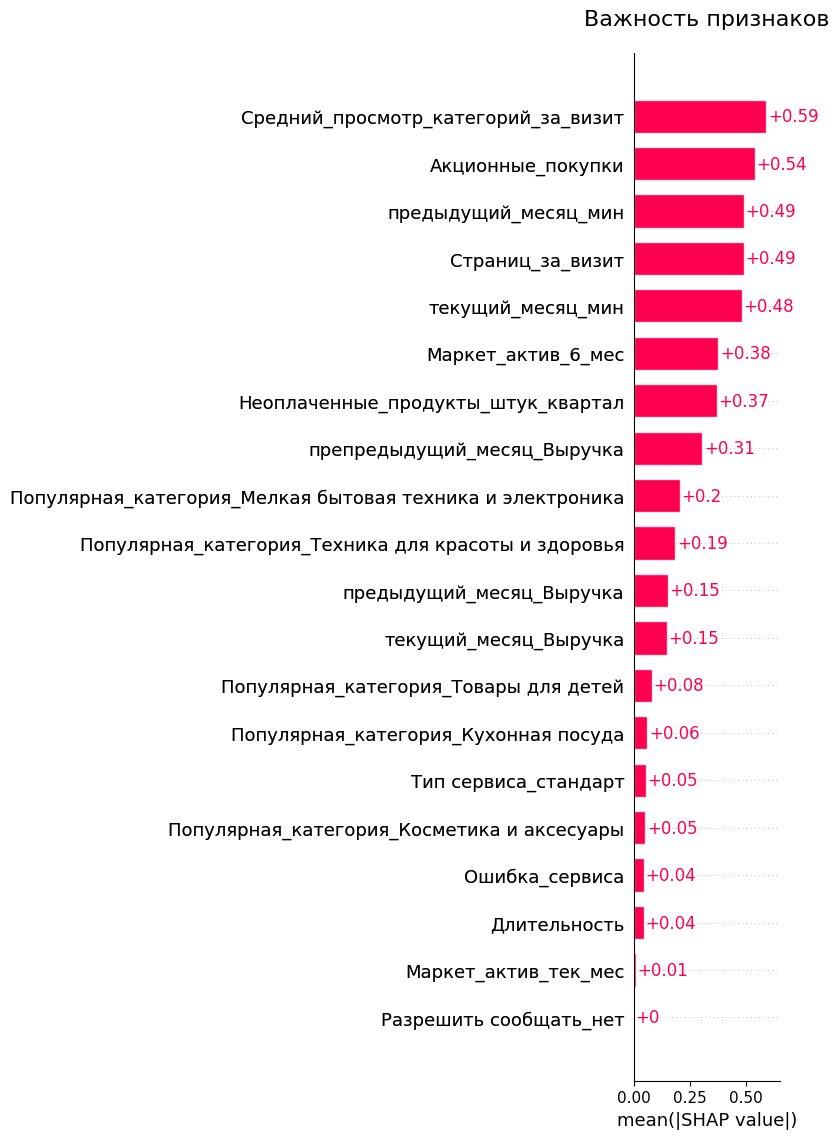

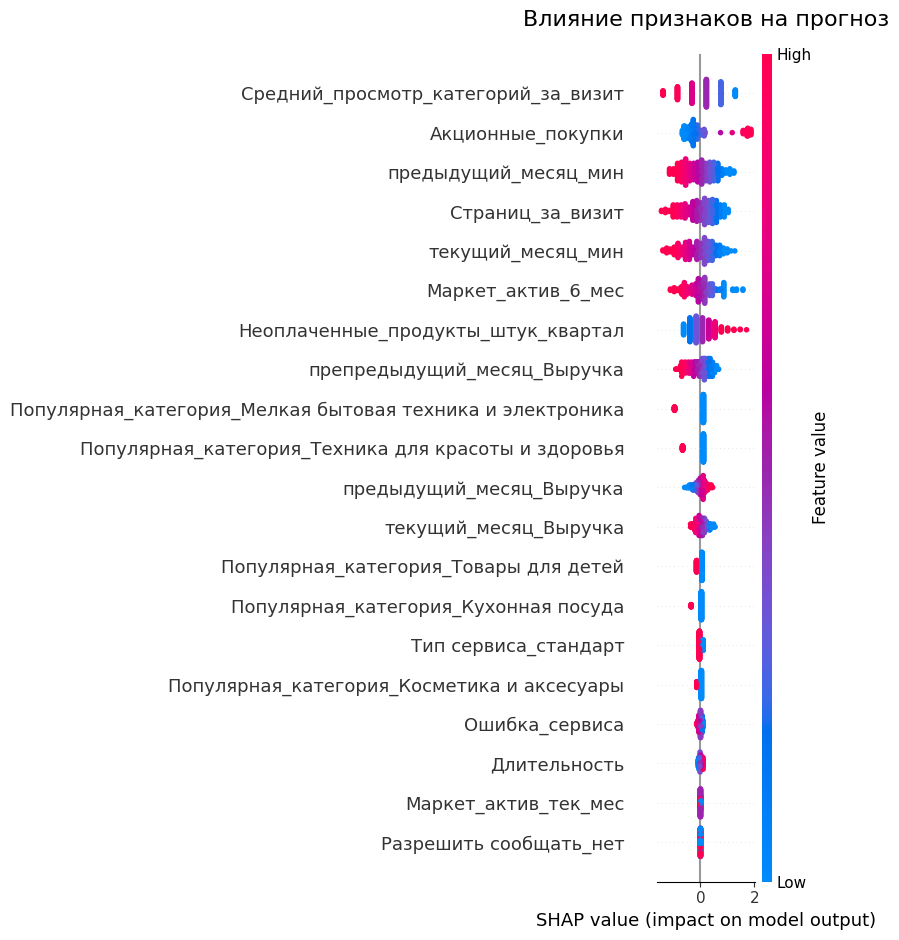

In [86]:
# 2. Обучение модели
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
model.fit(X_train_processed, y_train)

# 3. SHAP анализ
explainer = shap.Explainer(model, X_train_processed)
shap_values = explainer(X_test_processed)

# 4. Улучшенная визуализация


# График важности признаков (bar plot)
plt.figure(figsize=(16, 9))
shap.plots.bar(shap_values, max_display=22, show=False)
plt.title("Важность признаков", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Beeswarm plot
plt.figure(figsize=(16, 9))
shap.plots.beeswarm(shap_values, max_display=22, show=False)
plt.title("Влияние признаков на прогноз", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Использование наблюдений, полученных из анализа значений SHAP, помогает в моделировании и принятии бизнес-решений. 

   - Средний_просмотр_категорий_за_визит имеет наибольшее влияние на предсказания, как в положительном направлении, т.е. на увеличение активности клиентов и повышение выручки, так и в отрицательном, значит можно сосредоточиться на этих клиентах, изучить их поведение и сосредоточиться на приносящих прибыль, улучшить взаимодействие с теми, кто смотрит без совершения покупок.

   - Т.к. Акционные_покупки имеют высокую важность и демонстрируют неравномерное распределение, где значения в положительном диапазоне (+2) имеют значительное влияние, необходимо предлагать персонализированные услуги или акции, которые соответствуют интересам и поведению конкретных сегментов клиентов.

   - Неоплаченные_продукты_штук_квартал имеют высокую важность, значит небольшие неоплаченные продукиты сильно стимулируют совершить покупку. Делая акцент на этой категории клиентов, можно стимулировать их не только совершить запланированную покупку, но и готовить клиентов к новым покупкам

   - Длительность пребывания клиентом сайта также положительно влияет на целевые показатели, значит можно сосредоточиться на клиентах со стажем, которые делали покупки в предыдущем месяце, изучить их поведение и предложить персонификацию в этом сегменте.

Шаг 8. Сегментация покупателей

Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
•	Проведите графическое и аналитическое исследование группы покупателей.
•	Сделайте предложения по работе с сегментом для увеличения покупательской активности.

Сделайте выводы о сегментах:
•	какой сегмент вы взяли для дополнительного исследования,
•	какие предложения вы сделали и почему.

Тип сервиса имеет влияние на предсказания модели. Преобладание положительных значений указывает на высокую вероятность покупательской активности. Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Обучение pipeline...


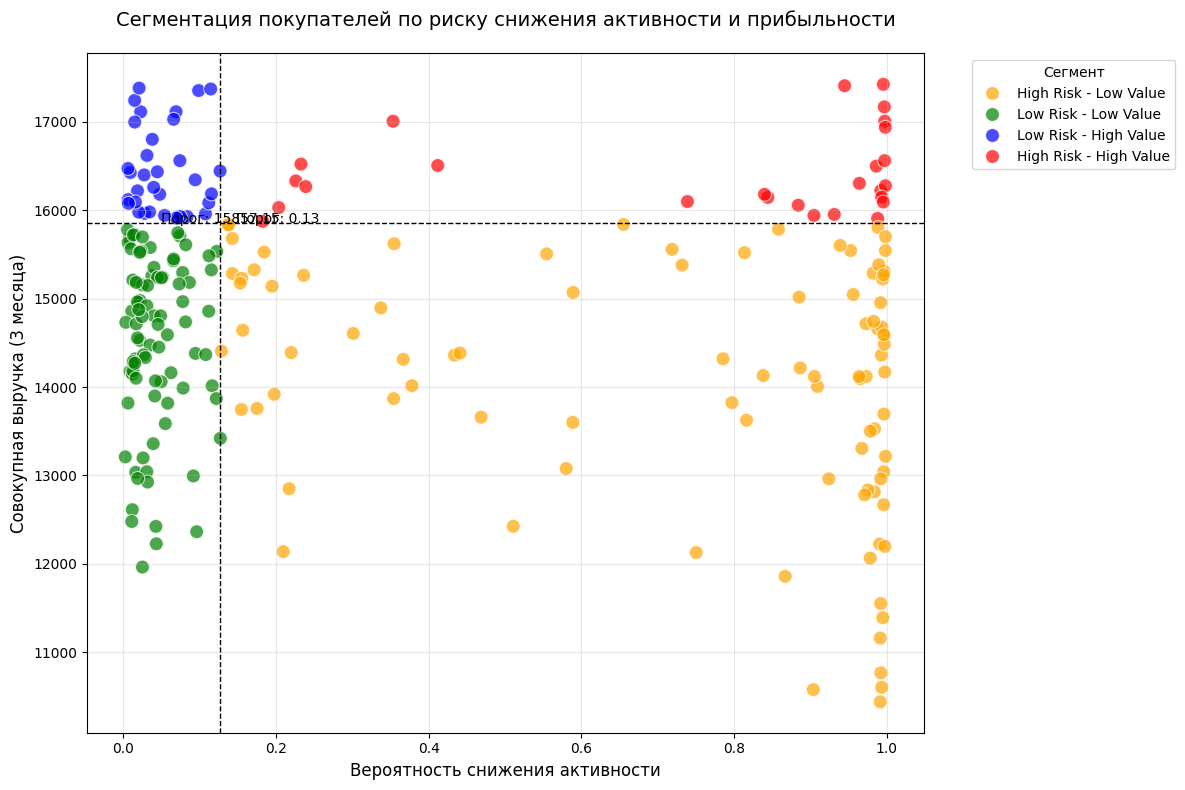

In [87]:
# 1. Проверяем, что pipeline обучен
if not hasattr(pipeline, 'classes_'):
    print("Обучение pipeline...")
    pipeline.fit(X_train, y_train)

# 2. Определяем прибыльность
joined_data['Profitability'] = (
    joined_data['текущий_месяц_Выручка'] + 
    joined_data['предыдущий_месяц_Выручка'] + 
    joined_data['препредыдущий_месяц_Выручка']
)

# 3. Получаем предсказанные вероятности
try:
    predicted_probabilities = pipeline.predict_proba(X_test)[:, 1]
except NotFittedError:
    pipeline.fit(X_train, y_train)
    predicted_probabilities = pipeline.predict_proba(X_test)[:, 1]

# 4. Создаем DataFrame с результатами
results = pd.DataFrame({
    'Predicted_Probability': predicted_probabilities,
    'Profitability': joined_data.loc[X_test.index, 'Profitability']
})

# 5. Определяем границы
probability_threshold = results['Predicted_Probability'].median()  # Используем медиану вместо среднего
profitability_threshold = results['Profitability'].quantile(0.75)

# 6. Уточненная сегментация
conditions = [
    (results['Predicted_Probability'] > probability_threshold) & (results['Profitability'] > profitability_threshold),
    (results['Predicted_Probability'] > probability_threshold) & (results['Profitability'] <= profitability_threshold),
    (results['Predicted_Probability'] <= probability_threshold) & (results['Profitability'] > profitability_threshold)
]
choices = ['High Risk - High Value', 'High Risk - Low Value', 'Low Risk - High Value']
results['Segment'] = np.select(conditions, choices, default='Low Risk - Low Value')

# 7. Визуализация с улучшениями
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=results, 
    x='Predicted_Probability', 
    y='Profitability', 
    hue='Segment',
    palette={'High Risk - High Value': 'red', 
             'High Risk - Low Value': 'orange',
             'Low Risk - High Value': 'blue',
             'Low Risk - Low Value': 'green'},
    alpha=0.7,
    s=100
)

plt.axvline(x=probability_threshold, color='black', linestyle='--', linewidth=1)
plt.axhline(y=profitability_threshold, color='black', linestyle='--', linewidth=1)
plt.title('Сегментация покупателей по риску снижения активности и прибыльности', fontsize=14, pad=20)
plt.xlabel('Вероятность снижения активности', fontsize=12)
plt.ylabel('Совокупная выручка (3 месяца)', fontsize=12)
plt.legend(title='Сегмент', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

# Добавляем аннотации
plt.text(probability_threshold+0.02, profitability_threshold+0.02, 
         f'Порог: {probability_threshold:.2f}', color='black')
plt.text(0.05, profitability_threshold+0.02, 
         f'Порог: {profitability_threshold:.2f}', color='black')

plt.show()

В среднем около 40% вероятности снижения активности у клиентов по порогу. Все клиенты с вероятностью выше считаются более рискованными в плане снижения активности.
Порог прибыльности (≈ 16000) - 75% клиентов имеют прибыльность ниже 16000, а 25% — выше. Клиенты с прибыльностью выше этого порога считаются более ценными.
High Risk - High Value -  группа включает клиентов, которые имеют высокую вероятность снижения активности (ближе к 1) и высокую прибыльность (в диапазоне от 16000 до 17500), несмотря на то, что они приносят значительную прибыль, они подвержены риску снижения активности. Это может быть связано с различными факторами, такими как неудовлетворенность продуктом, конкуренция или изменения в рынке.

Клиенты с высокой вероятностью снижения активности могут быть менее вовлечены или могут рассматривать альтернативные варианты. Если они уйдут, это может значительно повлиять на доход.

Эти клиенты приносят значительные доходы, потеря таких клиентов может негативно сказаться на финансовых результатах компании.

Следует обратить внимание на этих клиентов и разработать стратегии удержания: персонализированные предложения, улучшение качества обслуживания или программы лояльности. Возможно это связано с качеством продукта, ценами или уровнем обслуживания.

Необходимо продолжать отслеживать изменения в этом сегменте клиентов, проводить регулярный анализ, чтобы адаптировать стратегии и реагировать на изменения в поведении клиентов.

                   Популярная_категория  Текущий месяц  Предыдущий месяц  \
0                     Домашний текстиль      1149316.8         1106344.0   
1                 Косметика и аксесуары      1047887.2         1005775.0   
2                       Кухонная посуда       635387.7          604306.0   
3  Мелкая бытовая техника и электроника       794013.5          766031.0   
4        Техника для красоты и здоровья       880251.5          823684.5   
5                      Товары для детей      1585859.2         1498955.5   

   Препредыдущий месяц  Разница_с_предыдущим  Разница_с_препредыдущим  
0            1076084.0               42972.8                  73232.8  
1             969580.0               42112.2                  78307.2  
2             573000.0               31081.7                  62387.7  
3             759946.0               27982.5                  34067.5  
4             859974.0               56567.0                  20277.5  
5            1538076.0             

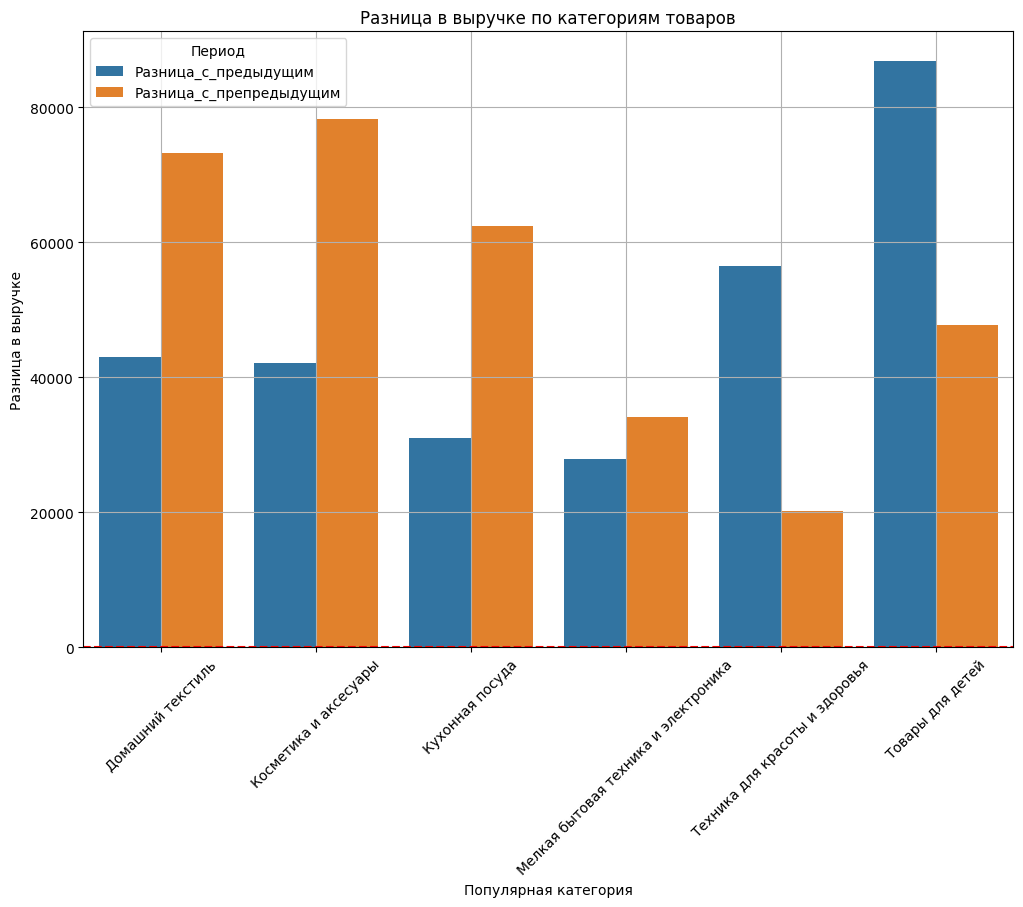

In [88]:
# Создаем DataFrame для агрегирования данных по категориям и периодам
# Будем использовать 'текущий_месяц_Выручка', 'предыдущий_месяц_Выручка', 'препредыдущий_месяц_Выручка'
categories = ['текущий_месяц_Выручка', 'предыдущий_месяц_Выручка', 'препредыдущий_месяц_Выручка']
period_labels = ['Текущий месяц', 'Предыдущий месяц', 'Препредыдущий месяц']

# Агрегируем данные по категориям
agg_data = joined_data.groupby('Популярная_категория')[categories].sum().reset_index()

# Переименовываем столбцы для удобства
agg_data.columns = ['Популярная_категория'] + period_labels

# Рассчитываем разницу в выручке между текущим месяцем и предыдущими
agg_data['Разница_с_предыдущим'] = agg_data['Текущий месяц'] - agg_data['Предыдущий месяц']
agg_data['Разница_с_препредыдущим'] = agg_data['Текущий месяц'] - agg_data['Препредыдущий месяц']

# Выводим результаты
print(agg_data)

# Визуализация разницы в выручке по категориям
plt.figure(figsize=(12, 8))
sns.barplot(data=agg_data.melt(id_vars='Популярная_категория', 
                                 value_vars=['Разница_с_предыдущим', 'Разница_с_препредыдущим'], 
                                 var_name='Период', value_name='Разница'),
             x='Популярная_категория', y='Разница', hue='Период')
plt.axhline(0, color='red', linestyle='--')
plt.title('Разница в выручке по категориям товаров')
plt.xlabel('Популярная категория')
plt.ylabel('Разница в выручке')
plt.xticks(rotation=45)
plt.legend(title='Период')
plt.grid()
plt.show()

Все категории товаров показывают положительную динамику в выручке за текущий месяц по сравнению с предыдущим месяцем, что свидетельствует о росте продаж и возможном увеличении спроса на данные товары.

Лидеры по росту - Товары для детей - демонстрирует наибольший прирост выручки как по сравнению с предыдущим месяцем (+73,595.6), так и с препредыдущим (+61,925.1), что может указывать на высокий спрос на товары для детей, возможно, из-за сезонных факторов или маркетинговых акций.

Косметика и аксессуары также показывает значительный рост (+43,903.6 по сравнению с предыдущим месяцем и +84,964.1 с препредыдущим), что может говорить о повышении интереса к данной категории.

Мелкая бытовая техника и электроника и Техника для красоты и здоровья показывают менее значительные увеличения в выручке, что может быть связано с насыщением рынка или изменениями в потребительских предпочтениях.

Все категории показывают положительную динамику по сравнению с препредыдущим месяцем, что указывает на устойчивый рост в долгосрочной перспективе. Наиболее заметный рост наблюдается у категорий «Косметика и аксессуары» и «Домашний текстиль», что может быть связано с изменениями в потребительском поведении или успешными акциями.

Следует проанализировать факторы, способствующие росту в категориях с высоким увеличением выручки, чтобы использовать эти уроки для других категорий.
Можно рассмотреть возможность проведения дополнительных маркетинговых кампаний для категорий с умеренным ростом, чтобы стимулировать спрос и увеличить продажи.

В целом, результаты анализа показывают положительную динамику и возможность для дальнейшего роста в продажах товаров. Необходимо следить за трендами в каждой категории и адаптировать ассортимент в зависимости от изменений в потребительских предпочтениях.

Шаг 9. Общий вывод

Общий вывод:
•	опишите задачу;
•	опишите исходные данные и проведённую предобработку;
•	напишите, что вы сделали для поиска лучшей модели;
•	укажите лучшую модель;
•	добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.

# Задача проекта: 

Разработка решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
Заказчик представил: 
- данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. market_file.csv
- данные о выручке, которую получает магазин с покупателя (сколько покупатель всего потратил за период взаимодействия с сайтом. market_money.csv
- данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. market_time.csv
- данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. money.csv

# Предварительный анализ 
Покупатели часто совершают покупки на сайте, проводя на нем значительное время. Они восприимчивы к акциям и сосредоточены на определенных категориях товаров. Однако они имеют привычку оставлять неоплаченные товары в корзине и сталкиваться с ошибками в обслуживании.

Клиенты со средней покупательской активностью являются лояльными, клиенты с высокой покупательской активностью приносят наибольшую выручку, а клиенты с низкой покупательской активностью могут быть новыми или нерегулярными покупателями.

Средняя длительность сеанса увеличивается с ростом покупательской активности. Клиенты с высокой покупательской активностью более вовлечены и проводят больше времени на сайте.

Бизнес генерирует значительную выручку, но она может сильно варьироваться. Распределение выручки асимметрично со сдвигом в сторону более высоких значений, что указывает на наличие нескольких очень прибыльных периодов.

Средняя выручка в текущем месяце выше, чем в предыдущие периоды, что указывает на положительную динамику роста выручки.

Сформированы 4 основные категории клиентов по покупательской активности:

-Покупатели premium_inactive сталкиваются с высокой маркетинговой активностью, это категория с длительным сроком регистрации - постоянные. Они умеренно интересуются акциями и просматривают относительно небольшое количество категорий за визит. Клиенты premium_inactive часто оставляют продукты в корзине и сталкиваются со сбоями в обслуживании, что может негативно влиять на их желание совершать покупки.

-Покупатели standart_inactive имеют средний стаж регистрации, подвержены умеренной маркетинговой активности и проявляют чуть меньший интерес к акциям, чем премиум-клиенты. Они просматривают несколько категорий за визит и исследуют сайт, но, вероятно, испытывают некоторые затруднения в поиске нужных товаров или услуг. Несмотря на меньшую вовлеченность, клиенты совершают более крупные покупки, что приводит к росту выручки.

-Премиум-активные покупатели имеют длительный стаж регистрации, часто сталкиваются и активно откликаются на маркетинговые мероприятия компании. Они проявляют меньший интерес к акциям, но тщательно исследуют сайт, просматривая большое количество категорий за визит. Несмотря на это, клиенты сталкиваются с проблемами в работе сервиса, что может негативно влиять на их опыт покупок.

-Клиенты сегмента стандарт-активные имеют средний стаж регистрации, высокий уровень маркетинговой активности и умеренный интерес к акциям. Они внимательно изучают сайт, просматривая несколько категорий за визит, что может указывать на серьезные намерения совершить покупку. Несмотря на наличие ошибок в работе сервиса, эти клиенты совершают относительно крупные покупки, обеспечивая стабильный доход.

# В ходе проведенного исследования разработана модель, которая предсказывает вероятность снижения покупательской активности.

Модель LogisticRegression показала наилучшие результаты среди протестированных моделей с точностью (Accuracy) на тестовой выборке - 86% предсказаний этой модели были верными. 

Выделен сегмент покупателей премиум, проведен его анализ и сформулировано предложение, как увеличить его покупательскую активность, используя данные моделирования, данные о прибыли покупателей и исходные данные.

# По данным Shap анализа:

   - Средний_просмотр_категорий_за_визит имеет наибольшее влияние на предсказания, как в положительном направлении, т.е. на увеличение активности клиентов и повышение выручки, так и в отрицательном, значит можно сосредоточиться на этих клиентах, изучить их поведение и сосредоточиться на приносящих прибыль, улучшить взаимодействие с теми, кто смотрит без совершения покупок.

   - Т.к. Акционные_покупки имеют высокую важность и демонстрируют неравномерное распределение, где значения в положительном диапазоне (+2) имеют значительное влияние, необходимо предлагать персонализированные услуги или акции, которые соответствуют интересам и поведению конкретных сегментов клиентов.

   - Неоплаченные_продукты_штук_квартал имеют высокую важность, значит небольшие неоплаченные продукиты сильно стимулируют совершить покупку. Делая акцент на этой категории клиентов, можно стимулировать их не только совершить запланированную покупку, но и готовить клиентов к новым покупкам

   - Длительность пребывания клиентом сайта также положительно влияет на целевые показатели, значит можно сосредоточиться на клиентах со стажем, которые делали покупки в предыдущем месяце, изучить их поведение и предложить персонификацию в этом сегменте.


# Для увеличения покупательской активности и выручки в популярных категориях премиум-сервиса (товары для детей, домашний текстиль, косметика и аксессуары), можно рассмотреть следующие стратегии:

1. Товары для детей. 
- Расширение ассортимента. Включить более разнообразные товары (экологически чистые игрушки, развивающие игры и образовательные наборы).
- Сезонные акции. Проведение акций во время начала учебного года или праздников (день защиты детей и др.) для стимулирования продаж.

2. Домашний текстиль. 
- Премиум-коллекции. Разработка эксклюзивных коллекций тканей, которые будут отличаться высоким качеством и уникальным дизайном.
- Кросс-продажи. Предлагать сопутствующие товары (декор, посуда и мебель), чтобы клиенты могли создать целостный интерьер.

3. Косметика. 
- Заключение новых контрактов с производителями. Введение органической или натуральной косметики, которая соответствует текущим трендам.
- Косметические наборы. Создание подарочных наборов с минимальной скидкой, чтобы стимулировать покупки.

4. Аксессуары.
- Персонализация. Внедрение услуги персонализации аксессуаров, таких как гравировка или выбор цвета.
- Сотрудничество с дизайнерами. Запуск лимитированных коллекций в сотрудничестве с известными дизайнерами или влиятельными личностями.